<div class="alert alert-block alert-success" style="background-color:lightblue; color:black;">

<b>Warning:</b> If you need to configure your environment, uncomment and run the following code cell. You may need to restart the runtime afterwards. (skip the colab setup cells.)

Also, if SWAN does not have any GPUs left, you can click on the button below to deploy the notebook in Google colaboratory. (do not run the next cell but follow the colab setup cells first!)

</div>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1d9Cp9v5Iwqapugj5p8vL7Yw1jqFvlDKs?usp=sharing)
[![Open In GitHub](https://img.shields.io/badge/Open_in_GitHub-blue?style=flat&logo=github&logoColor=white&labelColor=555)](https://github.com/francesco-vaselli/iCSC-exercise)

In [ ]:
# !pip install -r requirements.txt 

#### Colab setup

In [ ]:
!git clone https://github.com/francesco-vaselli/iCSC-exercise.git

In [ ]:
cd iCSC-exercise

In [ ]:
!pip install -r requirements.txt 

## Introduction: The Compact Muon Solenoid (CMS) experiment

The CMS experiment is a key research project at the Large Hadron Collider (LHC). It's a particle physics detector that observes and measures the byproducts of high-energy particle collisions in the LHC. CMS is designed to investigate a wide range of physics phenomena, and it played a pivotal role in the discovery of the Higgs boson in 2012.

CMS is a general-purpose detector, meaning it's equipped to study various aspects of particle physics. Its main components include a superconducting solenoid magnet, various particle detectors, and systems for tracking, energy measurement, and muon detection. This sophisticated setup allows scientists to explore several key questions in fundamental physics, such as the properties of the Higgs boson, the search for supersymmetry, the nature of dark matter, and potential evidence of extra dimensions.

<!-- insert cms image below -->
![A detailed picture of the CMS detector](gfx/cms_detect.png)


### Measuring jets at CMS

In CMS, particle jets are crucial for understanding high-energy processes. They are sprays of particles formed when quarks and gluons, produced in high-energy collisions like those at the LHC, hadronize or turn into ordinary matter. By analyzing the jets' energy and momentum, physicists can infer properties of the original particles, helping in studies like proton structure, the strong force, and new physics beyond the Standard Model.

![How a jet is generated and reconstructed](gfx/jet_structure.png)


## Hands-on generative models with CMS-like data

In High Energy Physics (HEP), simulations are crucial for understanding the outcomes of particle collisions, like those observed in the CMS experiment. The general simulation process involves several steps:

- **Event generation** - simulating the initial high-energy collision and the primary processes that follow
- **Particle tracking** and interaction - simulating how the particles produced in the collision travel through and interact with the detector material
- **Detector response** - modeling how the detector responds to these particles
- **Data reconstruction** - processing the simulated detector signals to reconstruct what happened in the collision

These steps are computationally expensive due to the complex physics involved and the high precision required. Each collision can produce a multitude of particles, making the simulation of even a single event a resource-intensive task.

Machine Learning (ML) can significantly speed up this process, particularly the reconstruction phase. By training models to emulate the behavior of particles in the detector and their interaction, we can bypass the need for detailed, step-by-step simulation, reducing computation time and resource usage.

In this exercise, we aim to simulate **reconstruction-level** (reco-level) jets from **generator-level** (gen-level) data. For this purpose, we have prepared a dataset about 2M pairs of gen jets and their associated reco jets as produced by a CMS-like simulation script.


<div class="alert alert-block alert-success" style="background-color:lightgreen; color:green;">

<b>Problem statement:</b> Learn to simulate the features of reco-jets given the values of the associated gen-jet features. This exercise will involve building different ML models for predicting the properties of the reco-jets (like momentum, pseudorapidity, etc.) based on the known properties of the gen-jets.
</div>


### The dataset

We start by loading the dataset and describing the input and the target features. We load some libraries and define some plotting utilities.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import nflows

from utils import plot_1dhistos, plot_corner, make_corner, plot_1d_hist, roc_curve_figure
from torchsummary import summary


In [2]:
# we set the device to use cuda if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

We pull the dataset from cernbox: it is a ttbar dataset of 400000 events, meaning more than 2M jets!

In [3]:
!curl -o data.npy https://cernbox.cern.ch/remote.php/dav/public-files/YzEDEoU01hJNI2G/gen_ttbar_400k_final.npy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100  445M  100  445M    0     0  23.4M      0  0:00:19  0:00:19 --:--:--  106M


We then extract the data. We are going to use just a subset of the features to reduce the complexity of the problem, and load 1M jets to split into trainig/validation/test. We are going to plot some histograms of the features to better understand what we are talking about.

In [4]:
# a class to load the data taking only some of the features and dividing into reco (target) and gen (input)
class DataExtractor():
    def __init__(self, data_path, n_samples=None):
        self.data = np.load(data_path, allow_pickle=True)
        self.n_samples = n_samples
        self.data = self.data[:n_samples]
        self.reco_features = ['btag', 'pt', 'phi', 'eta', 'N_const', 'ctag']
        self.reco = self.data[:, [5,  6,  7,  8, 10, 19]]
        self.gen_features = ["pt", "eta", "phi", "E", "flavour", "muonsInJet",]
        self.gen = self.data[:, [0, 1, 2, 3, 4, 9]]
        # collapse flavour to 3 categories: 0 (light), 1 (charm), 2 (bottom)
        self.gen[:, 4] = np.abs(self.gen[:, 4])
        self.gen[:, 4] = np.where(self.gen[:, 4] == 1, 0, self.gen[:, 4])
        self.gen[:, 4] = np.where(self.gen[:, 4] == 2, 0, self.gen[:, 4])
        self.gen[:, 4] = np.where(self.gen[:, 4] == 3, 0, self.gen[:, 4])
        self.gen[:, 4] = np.where(self.gen[:, 4] == 21, 0, self.gen[:, 4])
        self.gen[:, 4] = np.where(self.gen[:, 4] == 5, 2, self.gen[:, 4])
        self.gen[:, 4] = np.where(self.gen[:, 4] == 4, 1, self.gen[:, 4])

        
    def get_reco(self):
        return self.reco
    
    def get_gen(self):
        return self.gen

In [5]:
extractor = DataExtractor('data.npy', n_samples=500000)
reco_data = extractor.get_reco()
reco_features = extractor.reco_features
gen_data = extractor.get_gen()
gen_features = extractor.gen_features

#### Plots

We use some utilty functions to plot the target (reco) and input (gen) features to our models. We can use the same functions later on when validating our models!

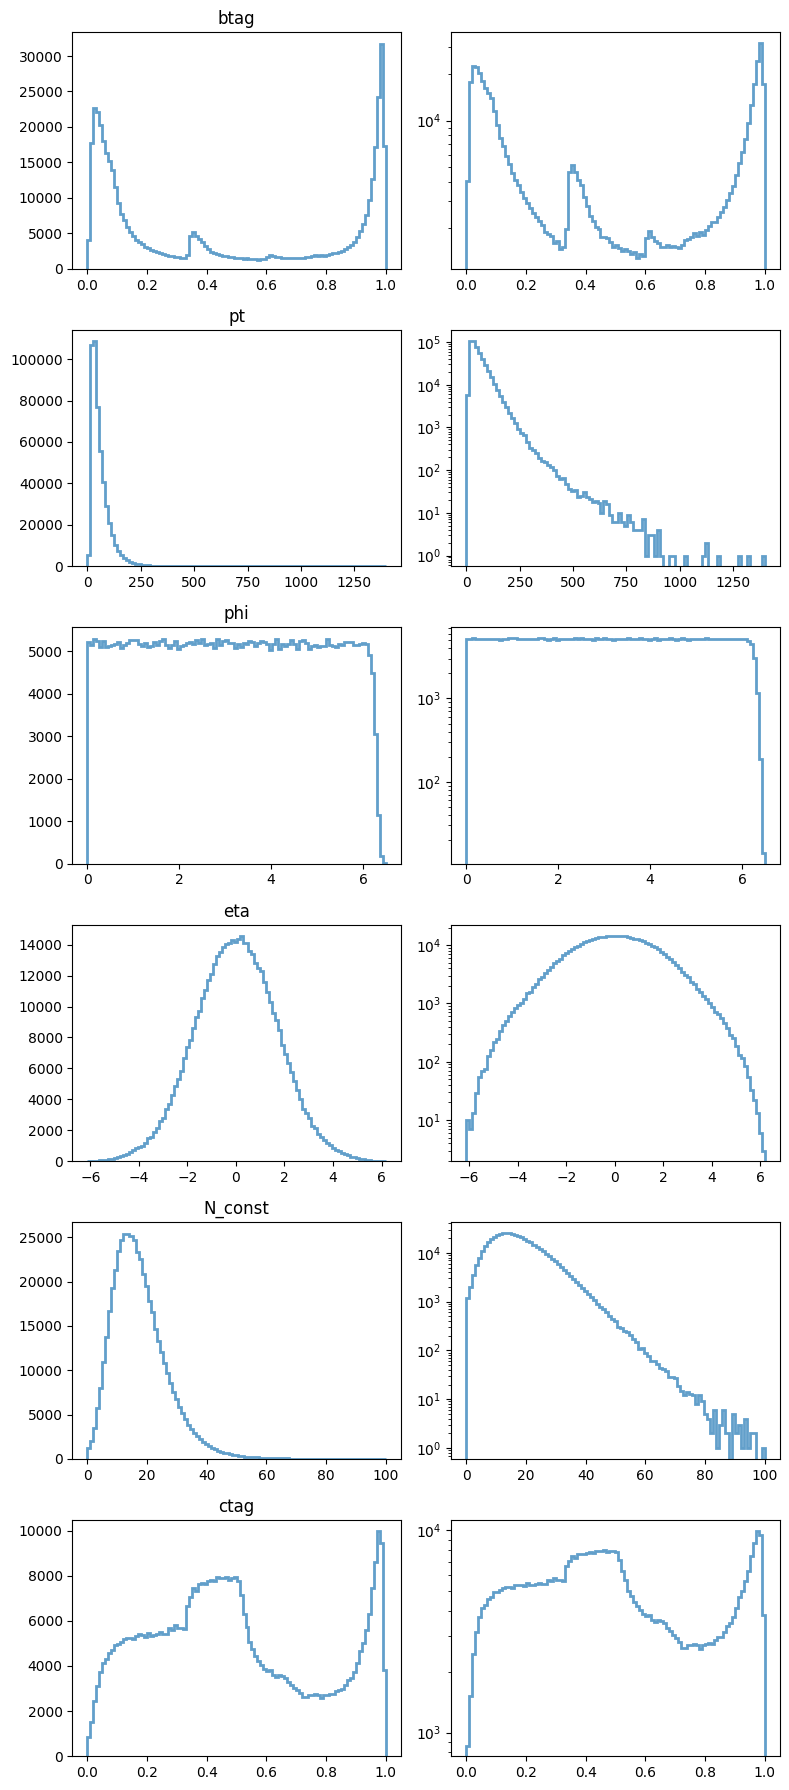

In [6]:
# plot the targets
plot_1dhistos(reco_data, reco_features)

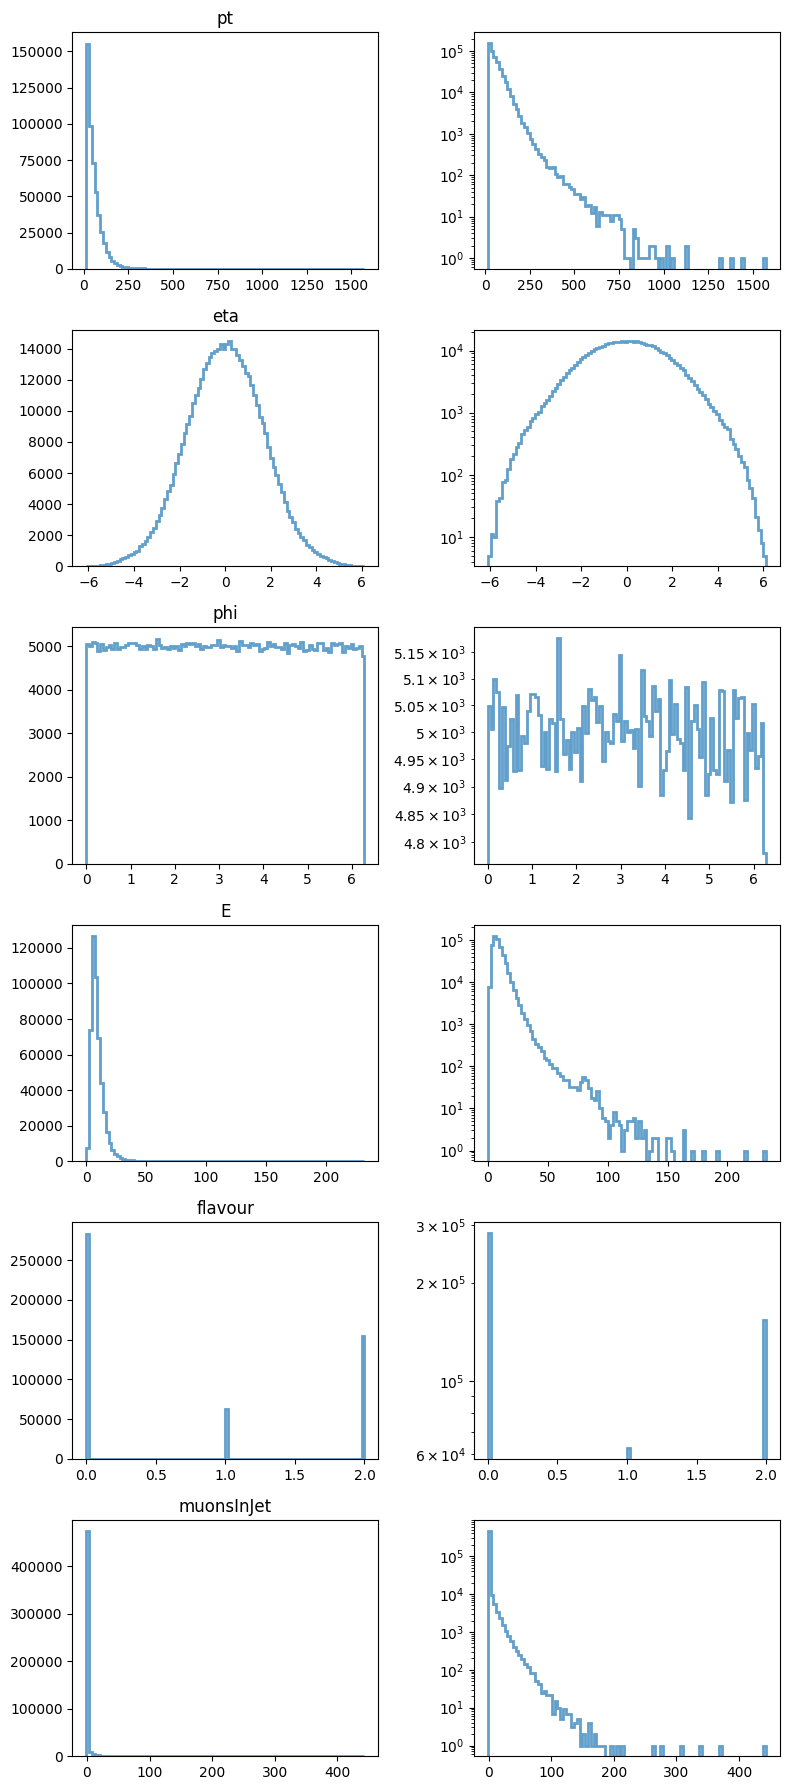

In [7]:
# plot the inputs
plot_1dhistos(gen_data, gen_features)

We can also plot the correlations between the different distributions. We would like our models to capture these as well!

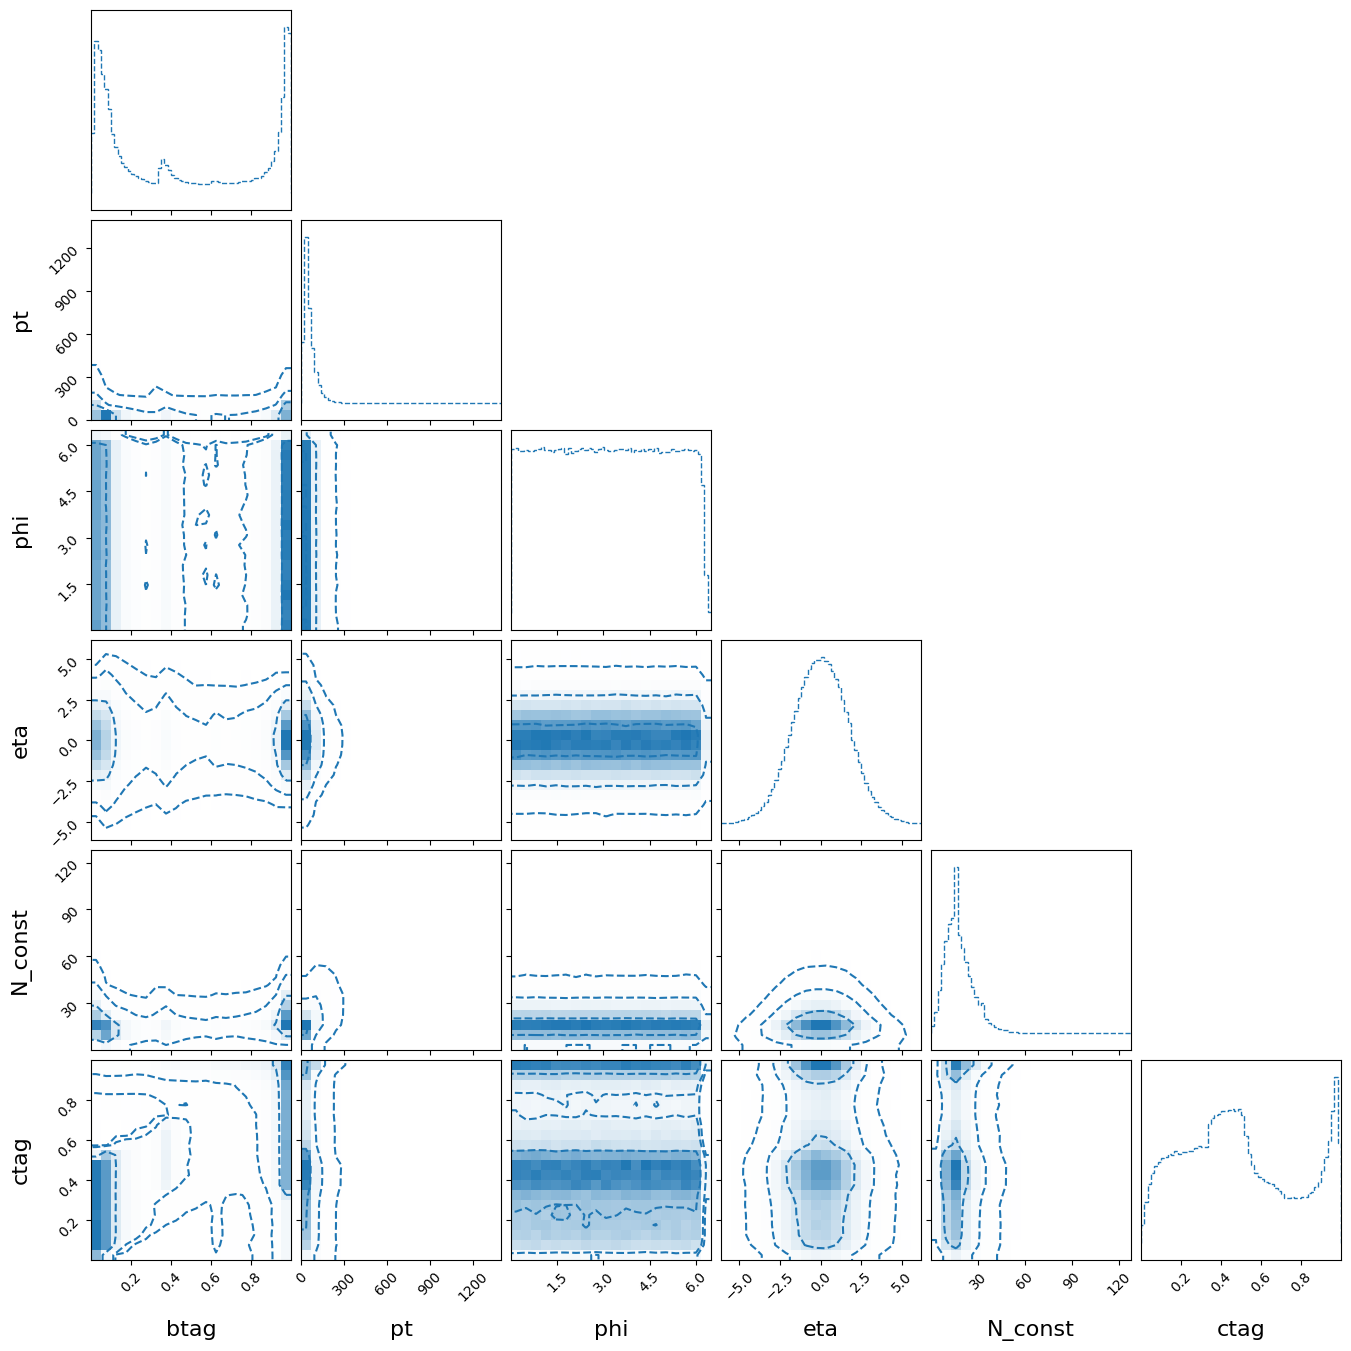

In [8]:
plot_corner(reco_data, reco_features)

As we give the gen flavour as input, we would like our model to capture the correct response of the b and c-tagging distributions. The plot below shows that a flavour of b corresponds to higher values in the b-tagging score, but also in the c-tagging one, as the jets originating from the two quarks have similar features.

![Correlations between tagger score and input flavour](gfx/taggers_correlations.png)

An extremely important figure of merit when studying jets is the Receiver operating characteristic (ROC) curve, a graphical plot that illustrates the performance of a binary classifier model at varying threshold values. This is also a way to take into account the correlations discussed above, as we would like our model to have a similar performance to that of the training data.

![How to build a ROC curve](gfx/ROC_curves.svg.png)

Below we show the performance for the target data: we follow the CMS convention of putting the True Positives on the x-axis, so the best performing curves are on the bottom right. The figures display the b/c quarks tagging efficiency against light (uds) quarks and gluons. We also show colored bands displaying the typical data-vs-simulation discrepancy for large LHC experiments.

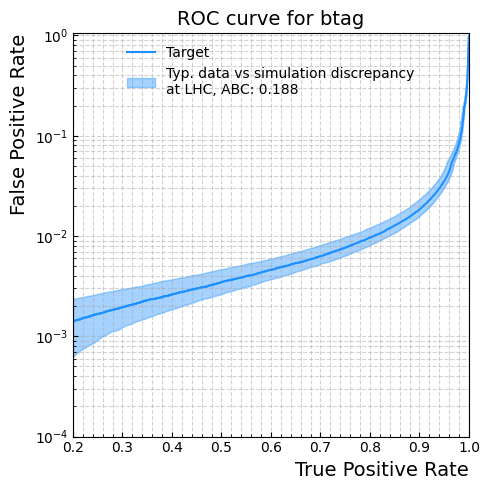

In [9]:

roc = roc_curve_figure(reco_data, gen_data, mode='btag')

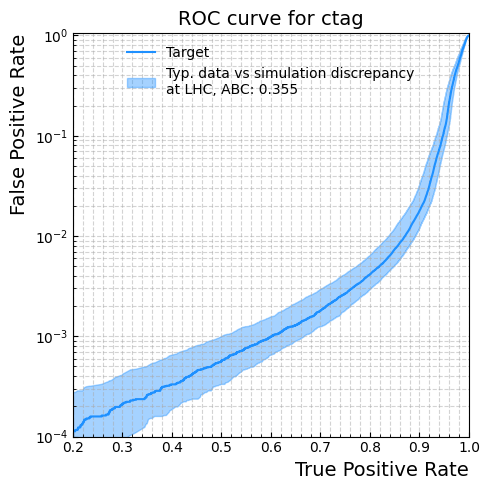

In [10]:
ctag = roc_curve_figure(reco_data, gen_data, mode='ctag')

#### Preprocessing

We need to preprocess our data. 
The proposed approach is very simple: 
- we standard scale all input features (except for discrete ones);
-  for targets we learn the ratio $p_T^{\text{reco}}/p_T^{\text{gen}}$, the differences $\eta^{\text{reco}} - \eta^{\text{gen}}$ and $\phi^{\text{reco}} - \phi^{\text{gen}}$;
- we standard scale the rest. 
- We also apply some uniform smearning for the number of constituents. 

Feel free to change or add some operations if you think you need them!

In [11]:
### Preprocessor class with transform and invert methods
from sklearn.preprocessing import StandardScaler

class Preprocessor():
    def __init__(self):
        self.reco_features = ['btag', 'pt', 'phi', 'eta', 'N_const', 'ctag']
        self.gen_features = ["pt", "eta", "phi", "E", "flavour", "muonsInJet",]
        self.reco_scaler = StandardScaler()
        self.gen_scaler = StandardScaler()

    def transform(self, reco, gen):
        wreco = np.copy(reco)
        wgen = np.copy(gen)
        # smear N_const
        wreco[:, 4] = wreco[:, 4] + np.random.uniform(-0.5, 0.5, len(wreco))
        # pt ratio
        wreco[:, 1] = wreco[:, 1] / wgen[:, 0]
        # eta difference
        wreco[:, 3] = wreco[:, 3] - wgen[:, 1]
        # phi difference
        wreco[:, 2] = wreco[:, 2] - wgen[:, 2]

        # standard scale the rest
        wreco[:, [0, 4, 5]] = self.reco_scaler.fit_transform(wreco[:, [0, 4, 5]])
        wgen[:, [0, 1, 2, 3]] = self.gen_scaler.fit_transform(wgen[:, [0, 1, 2, 3]])



        return wreco, wgen
    
    def invert(self, reco, gen):

        wreco = np.copy(reco)
        wgen = np.copy(gen)
        
        # invert standard scaling
        wreco[:, [0, 4, 5]] = self.reco_scaler.inverse_transform(wreco[:, [0, 4, 5]])
        wgen[:, [0, 1, 2, 3]] = self.gen_scaler.inverse_transform(wgen[:, [0, 1, 2, 3]])

        # invert pt ratio
        wreco[:, 1] = wreco[:, 1] * wgen[:, 0]
        # invert eta difference
        wreco[:, 3] = wreco[:, 3] + wgen[:, 1]
        # invert phi difference
        wreco[:, 2] = wreco[:, 2] + wgen[:, 2]

        # invert N_const smearing
        wreco[:, 4] = np.rint(wreco[:, 4])

        return wreco, wgen


preprocessor = Preprocessor()
reco_data_transf, gen_data_transf = preprocessor.transform(reco_data, gen_data)

# split the data into training and validation
from sklearn.model_selection import train_test_split

reco_train, reco_val, gen_train, gen_val = train_test_split(reco_data_transf, gen_data_transf, test_size=0.2)
print("Ready to train!")
print("Target data shape: ", reco_train.shape)
print("Input data shape: ", gen_train.shape)
print("Validation data shape: ", reco_val.shape)    
print("Validation data shape: ", gen_val.shape)

# move to torch
reco_train_torch = torch.tensor(reco_train, dtype=torch.float32).to(device)
gen_train_torch = torch.tensor(gen_train, dtype=torch.float32).to(device)
reco_val_torch = torch.tensor(reco_val, dtype=torch.float32).to(device)
gen_val_torch = torch.tensor(gen_val, dtype=torch.float32).to(device)

Ready to train!
Target data shape:  (400000, 6)
Input data shape:  (400000, 6)
Validation data shape:  (100000, 6)
Validation data shape:  (100000, 6)


Great! So the arrays (or tensors, as Pytorch likes to call them) we just defined are what we are going to use for our trainings and validations (you can still load data by increasing the `n_samples` in the extractor above, but more data will require more time for training!) We have them on the CPU and we also sent some copies on the GPU for parallelization and faster training. Notice the `to(device)` syntax used to move things around in Pytorch.

Let's see how the pre-processed features look like: this is what we'll be using as the final target to our models!

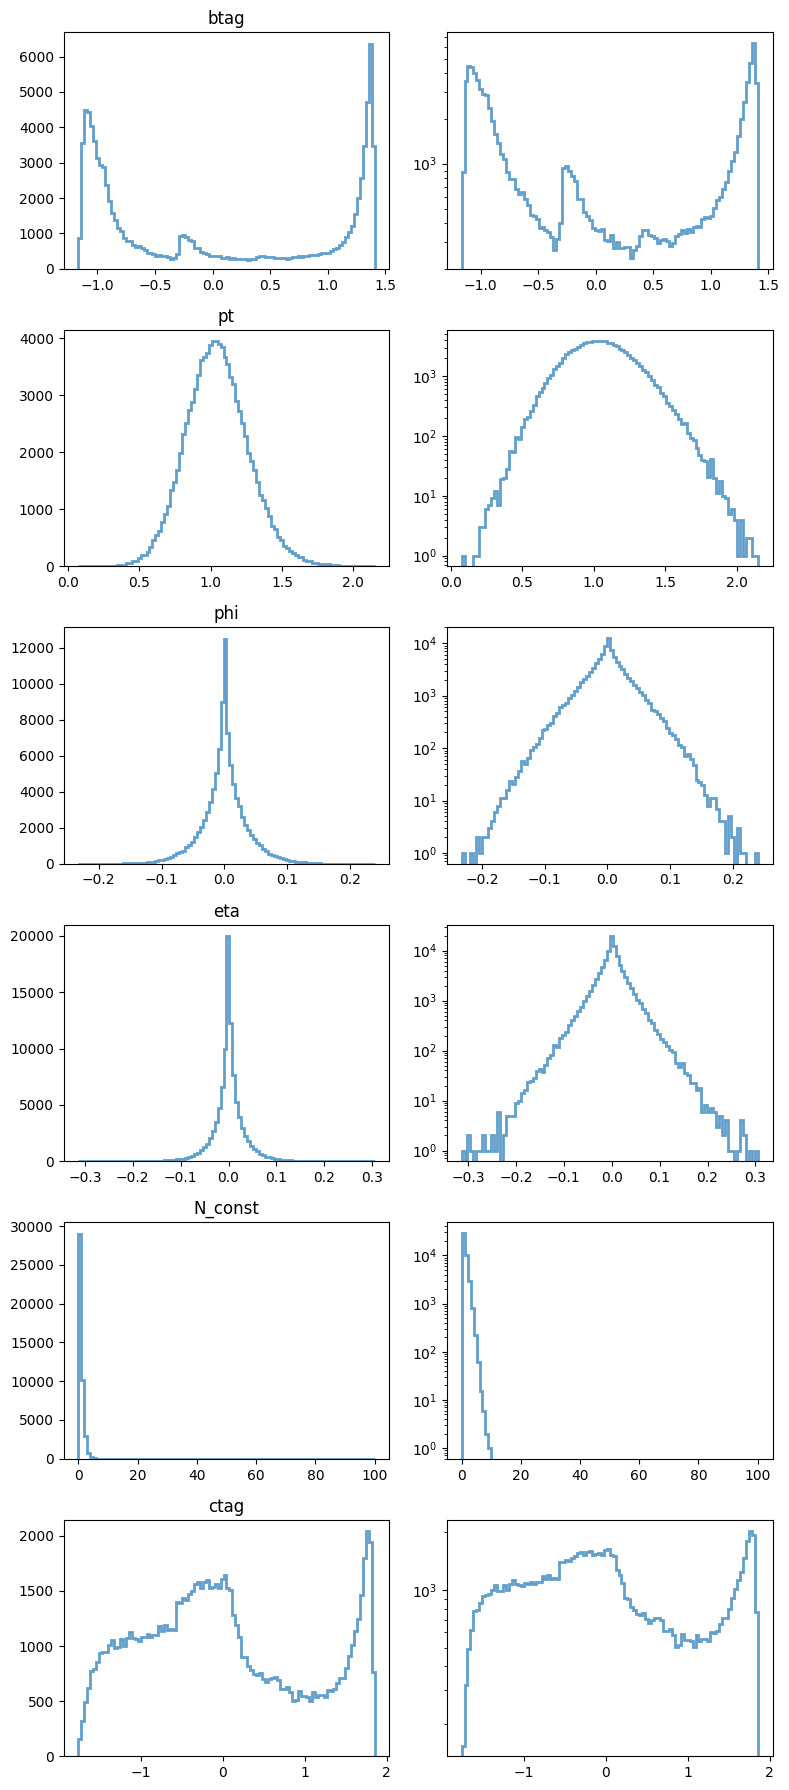

In [12]:
# plot the transformed data
plot_1dhistos(reco_val, reco_features)

Let's check that the transformation back to the physical space works as expected. We'll also be using this function to send data coming from the models to the physical space.

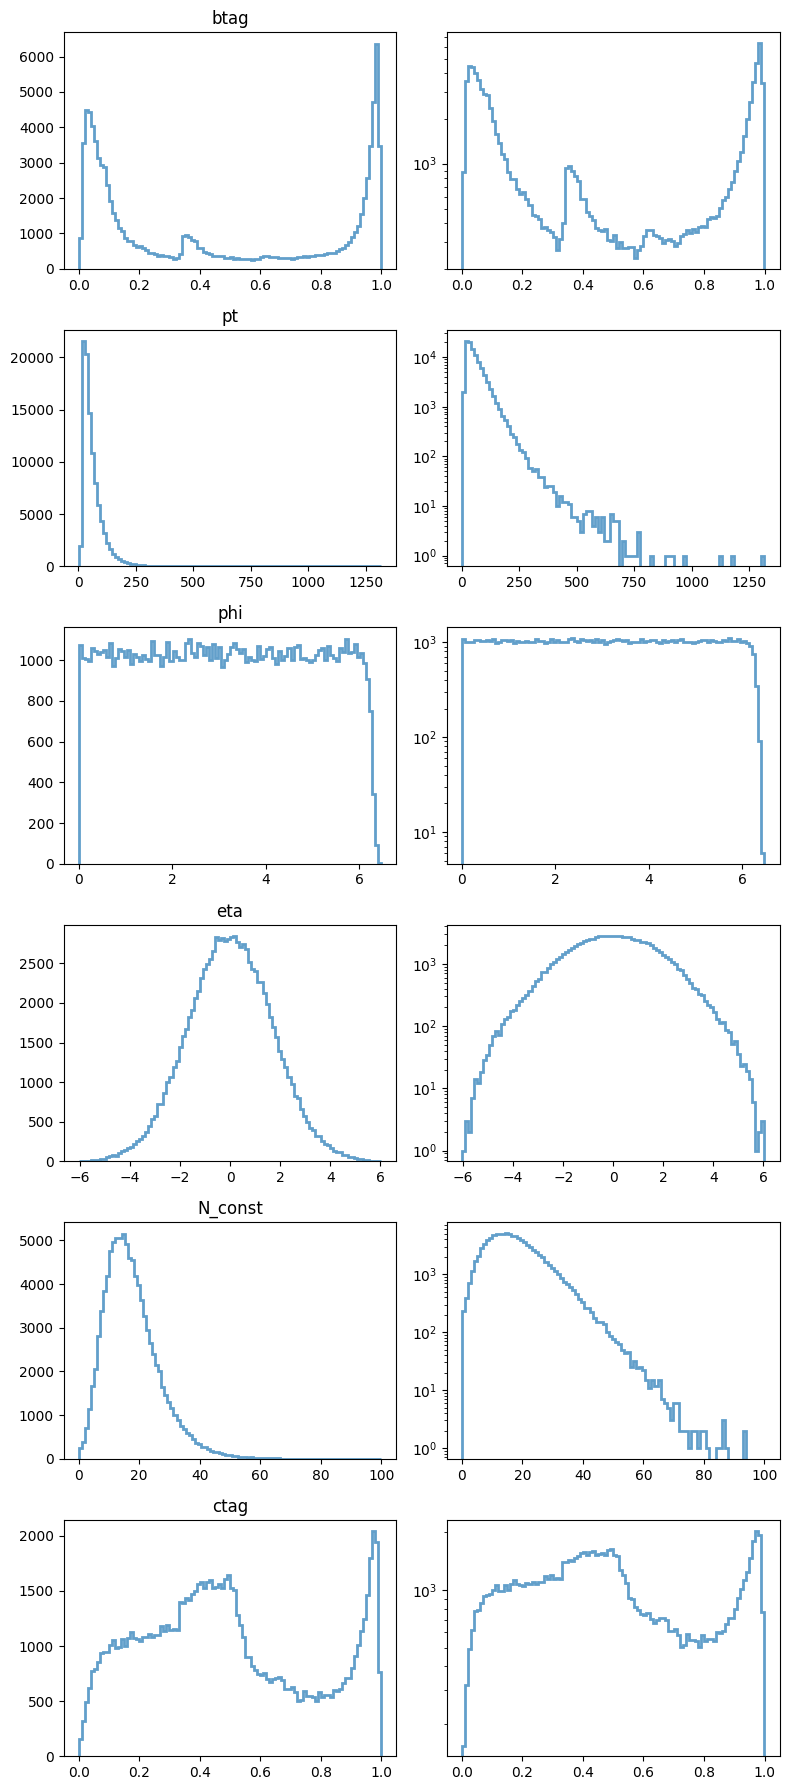

In [13]:
# now postprocess the data and plot it
reco_val_post, gen_val_post = preprocessor.invert(reco_val, gen_val)
plot_1dhistos(reco_val_post, reco_features)

Cool! Everything is ready to start discussing the actual models!

### Normalizing Flows


It can be really hard to learn $p(\mathbf{x})$, the probability density function of real data! Taking the generative model with latent variables as an example, $p(\mathbf{x}) = \int p(\mathbf{x}\vert\mathbf{z})p(\mathbf{z})d\mathbf{z}$ can hardly be calculated as it is intractable to go through all possible values of the latent code.

Flow-based deep generative models conquer this hard problem with the help of normalizing flows [[9][9]], a powerful statistics tool for _density estimation_. A good estimation of $p(\mathbf{x})$ makes it possible to efficiently complete many downstream tasks: sample unobserved but realistic new data points (**data generation**), predict the rareness of future events (density estimation), infer latent variables, fill in incomplete data samples, etc.

A Normalizing Flows (NF) transforms a simple distribution into a complex one by applying a sequence of invertible transformation functions. Flowing through a chain of transformations, we repeatedly substitute the variable for the new one according to the **change of variables theorem** and eventually obtain a probability distribution of the final target variable. During training we learn $z=f(x)$ sending data into the Gaussian space, then we can invert $f$ to get new samples $\hat{x}= f^{-1}(z)$.

Normalizing flows can be easily implemented through [nflows](https://github.com/bayesiains/nflows), a Python package that offers a comprehensive collection of flow-based models.

[9]: https://arxiv.org/abs/1912.02762

<div align="center">
  <img src="https://lilianweng.github.io/posts/2018-10-13-flow-models/normalizing-flow.png" width="800"/>
</div>

The Flow-based model presented in this hands-on is designed for complex distributions and data transformations, and is made of several key components relying on the [nflows](https://github.com/bayesiains/nflows) package.

The `FlowModel` class is defined as a PyTorch module that encapsulates the normalizing flow model. The constructor takes the number of layers, the number of MLP blocks, and the number of hidden features as parameters. These hyperparameters determine the architecture of the flow model.

The `build_flow` method is responsible for constructing the normalizing flow:

- **Base Distribution:** The model begins with a base distribution, specifically a standard normal distribution with a shape of 6 (the target variables). This serves as the starting point for generating more complex distributions through a series of transformations.
- **Transformations:**
  1. **Random Permutation:** At each layer, a random permutation of the features is applied. This helps in correlating the input data, making the model more flexible.
  2. **Masked Affine Autoregressive Transform:** This transformation applies an affine transformation $y = Wx + c$, allowing the model to scale and shift the data in a complex, learned manner. The autoregressive property ensures that the transformation of each dimension depends only on the previous dimensions, making the Jacobian of the transform more tractable.
     - The transformation uses `num_mlp_blocks` blocks with `hidden_features` hidden features each, and batch normalization is employed to stabilize and speed up training.
- **Composite Transformation:** All the individual transformations are combined into a single composite transformation. The total number of transformations is given by `num_layers`. This sequential application of transformations allows the model to learn complex and high-dimensional distributions.
- **Flow Model:** The final model, termed `flow`, uses the composite transformation to mold the base distribution into the target distribution. It is capable of both forward and backward operations, crucial for tasks like density estimation and generative modeling.

The `forward` method computes the negative log-likelihood of the input data given the flow model. It takes the reconstructed data (x) and the generated data (gen) as inputs and returns the negative log-likelihood.

The `train` method performs the training of the flow model using the Adam optimizer. It iterates over the specified number of epochs and performs mini-batch gradient descent. The loss is computed as the mean negative log-likelihood of the reconstructed data. The method also validates the model on a validation set and prints the training and validation losses for each epoch.

The `sample` method generates samples from the learned flow model. It takes the generated data (gen) as input and returns samples from the target distribution.


In [14]:
from nflows.distributions.normal import StandardNormal
from nflows.transforms.permutations import RandomPermutation
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.base import CompositeTransform
from nflows.flows.base import Flow
from torch import optim
import numpy as np


class FlowModel(nn.Module):
    def __init__(self, num_layers, num_mlp_blocks, hidden_fatures):
        super(FlowModel, self).__init__()
        self.num_layers = num_layers
        self.num_mlp_blocks = num_mlp_blocks
        self.hidden_features = hidden_fatures
        self.flow = self.build_flow(num_layers, num_mlp_blocks, hidden_fatures)

    def build_flow(self, num_layers=1, num_mlp_blocks=2, hidden_features=64):
        base_dist = StandardNormal(shape=[reco_val.shape[1]])
        transforms = []

        # Constructing layers of the flow model
        for _ in range(num_layers):
            transforms.append(RandomPermutation(features=reco_val.shape[1]))
            transforms.append(MaskedAffineAutoregressiveTransform(
                features=reco_val.shape[1],
                use_residual_blocks=False,
                num_blocks=num_mlp_blocks,
                hidden_features=hidden_features,
                use_batch_norm=True,
                context_features=gen_val.shape[1]
            ))

        # Combining all transforms into a composite transform
        transform = CompositeTransform(transforms)

        # Creating the flow model with the specified transform and base distribution
        flow = Flow(transform, base_dist)

        return flow
    
    def forward(self, x, gen):
        return -self.flow.log_prob(inputs=x, context=gen) # take gen info into account to model p(x|gen)
    
    def train(self, reco, gen, reco_val, gen_val, num_epochs, batch_size, lr):
        optimizer = optim.Adam(self.parameters(), lr=lr)

        loss_train = []
        loss_val = []

        for epoch in range(num_epochs):
            loss_epoch = 0

            for batch_idx in range(len(reco) // batch_size):
                reco_batch = reco[batch_idx * batch_size: (batch_idx + 1) * batch_size]
                gen_batch = gen[batch_idx * batch_size: (batch_idx + 1) * batch_size]

                loss = torch.mean(self(reco_batch, gen_batch))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                loss_epoch += loss.item()

            loss_train.append(loss_epoch / (len(reco) // batch_size))

            # validate
            with torch.no_grad():
                loss_val_epoch = torch.mean(self(reco_val, gen_val))
            
            loss_val.append(loss_val_epoch.item())

            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss_train[-1]:.4f}, Val Loss: {loss_val[-1]:.4f}")
        
        return loss_train, loss_val
    
    def sample(self, gen):
        self.flow.eval()
        return self.flow.sample(num_samples=1, context=gen)


# here we set the hyperparameters
num_layers = 10
num_mlp_blocks = 3
hidden_fatures = 64

# Building the flow model and setting the device
flow = FlowModel(num_layers=num_layers, num_mlp_blocks=num_mlp_blocks, hidden_fatures=hidden_fatures).to(device)

# Print the number of trainable parameters in the model
print(f"Number of trainable parameters: {sum(p.numel() for p in flow.parameters() if p.requires_grad)}")
# summary(flow, [(6,), (6,)])



Number of trainable parameters: 145400


We can train our model with a reasonable choice of hyperparameters.

In [15]:
#train
num_epochs = 50
batch_size = 128
lr = 0.001

loss_train, loss_val = flow.train(reco_train_torch, gen_train_torch, reco_val_torch, gen_val_torch, num_epochs, batch_size, lr)

Epoch [1/50], Loss: -2.6164, Val Loss: -3.4768
Epoch [2/50], Loss: -3.4528, Val Loss: -3.6066
Epoch [3/50], Loss: -3.5677, Val Loss: -3.2556
Epoch [4/50], Loss: -3.6246, Val Loss: -3.7121
Epoch [5/50], Loss: -3.6717, Val Loss: -3.7264
Epoch [6/50], Loss: -3.7062, Val Loss: -3.7698
Epoch [7/50], Loss: -3.7258, Val Loss: -3.7721
Epoch [8/50], Loss: -3.7381, Val Loss: -3.8117
Epoch [9/50], Loss: -3.7552, Val Loss: -3.8122
Epoch [10/50], Loss: -3.7665, Val Loss: -3.7836
Epoch [11/50], Loss: -3.7812, Val Loss: -3.8228
Epoch [12/50], Loss: -3.7886, Val Loss: -3.8304
Epoch [13/50], Loss: -3.7760, Val Loss: -3.8265
Epoch [14/50], Loss: -3.8113, Val Loss: -3.8023
Epoch [15/50], Loss: -3.8139, Val Loss: -3.8265
Epoch [16/50], Loss: -3.8190, Val Loss: -3.8469
Epoch [17/50], Loss: -3.8178, Val Loss: -3.7797
Epoch [18/50], Loss: -3.8388, Val Loss: -3.8384
Epoch [19/50], Loss: -3.8414, Val Loss: -3.8462
Epoch [20/50], Loss: -3.8228, Val Loss: -3.8493
Epoch [21/50], Loss: -3.8486, Val Loss: -3.8740
E

We can see how the training went and check for overfitting by looking at the train/validation losses.

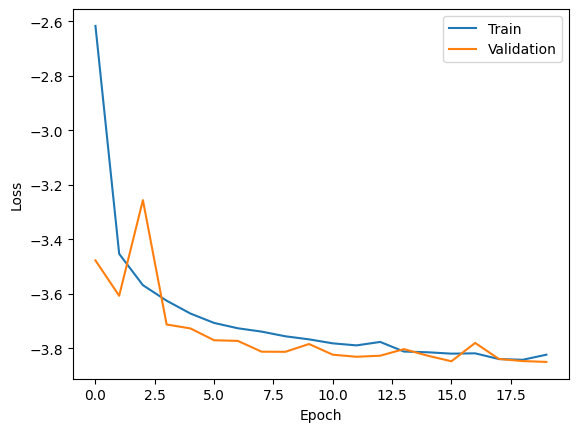

In [16]:
# plot the loss, some instabilties can happen, so we show only the first 20 epochs
plt.plot(loss_train[:20], label="Train")
plt.plot(loss_val[:20], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


#### Results

We are now ready to generate new, original samples from noise and the validation gen data!

In [17]:
# generate in batches
with torch.no_grad():
    batch_size = 5000
    num_samples = len(gen_val_torch)
    num_batches = num_samples // batch_size
    samples = []

    for i in range(num_batches):
        gen_batch = gen_val_torch[i * batch_size: (i + 1) * batch_size]
        sample = flow.sample(gen_batch)
        # print(sample)
        samples.append(sample)

    samples = torch.cat(samples, dim=0).view(-1, reco_train_torch.shape[1]).cpu().numpy()
    print(samples.shape)
    samples, _ = preprocessor.invert(samples, gen_val)
    reco_val_phys, _ = preprocessor.invert(reco_val, gen_val)

(100000, 6)


We can check the 1d histograms and compare them against the validation data generated from the same gen information:

/home/users/fvaselli/iCSC/utils.py:342: RuntimeWarning: invalid value encountered in divide
  (np.sqrt(hist_flash) / hist_flash) ** 2 + (np.sqrt(hist_reco) / hist_reco) ** 2
/home/users/fvaselli/iCSC/utils.py:344: RuntimeWarning: divide by zero encountered in divide
  ratio_err = ratio_err * (hist_flash / hist_reco)
/home/users/fvaselli/iCSC/utils.py:344: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio_err * (hist_flash / hist_reco)
/home/users/fvaselli/iCSC/utils.py:345: RuntimeWarning: divide by zero encountered in divide
  ratio = hist_flash / hist_reco
/home/users/fvaselli/iCSC/utils.py:345: RuntimeWarning: invalid value encountered in divide
  ratio = hist_flash / hist_reco


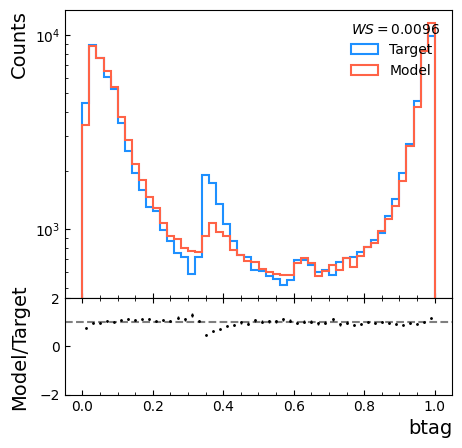

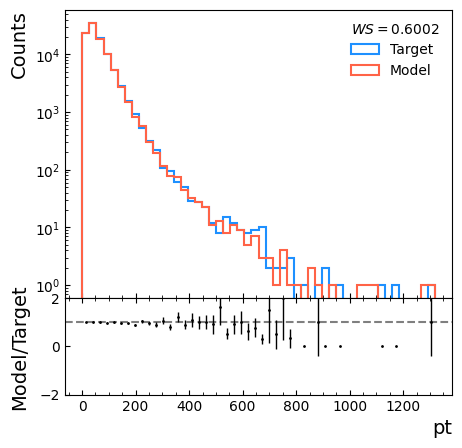

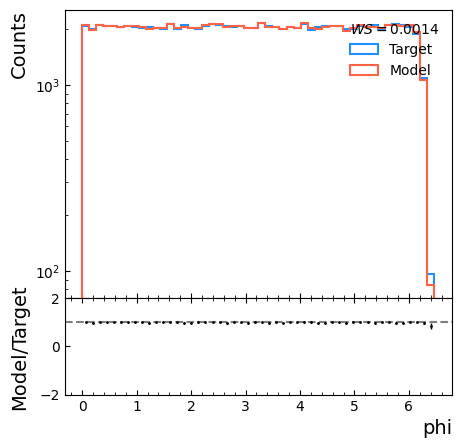

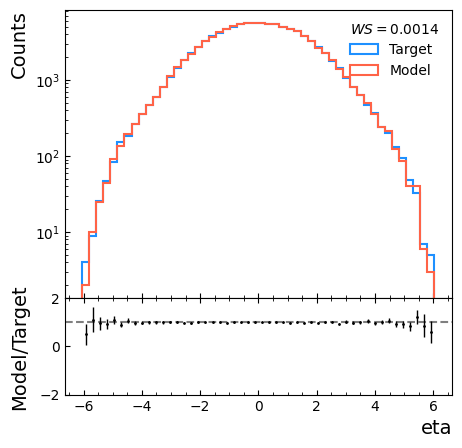

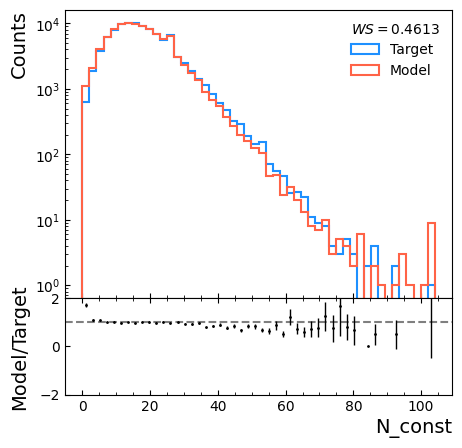

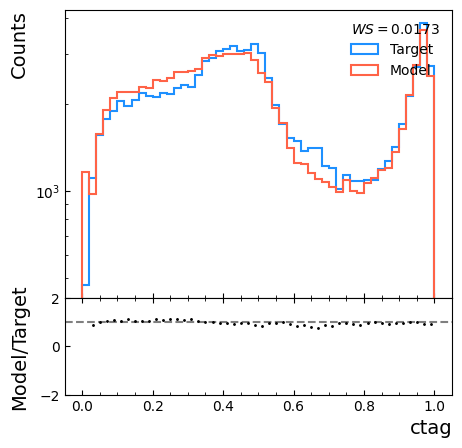

In [18]:
# plot
for i in range(6):
    plot_1d_hist(samples[:, i], reco_val_phys[:, i], label=reco_features[i], title=f'Generated vs Real {reco_features[i]}', bins=50, logScale=True)

We can se a good level of accuracy, even if some distributions which are more complex are not recovered completely. We also report the Wasserstein distance or score (WS), a distance function defined between probability distributions.

Intuitively, if each distribution is viewed as a unit amount of earth (soil), the metric is the minimum "cost" of turning one pile into the other, which is assumed to be the amount of earth that needs to be moved times the mean distance it has to be moved. Because of this analogy, the metric is known in computer science as the earth mover's distance. 

Next, we chek the modelling of the correlations between the different variables with the corner plot, showing again a good level of agreement.

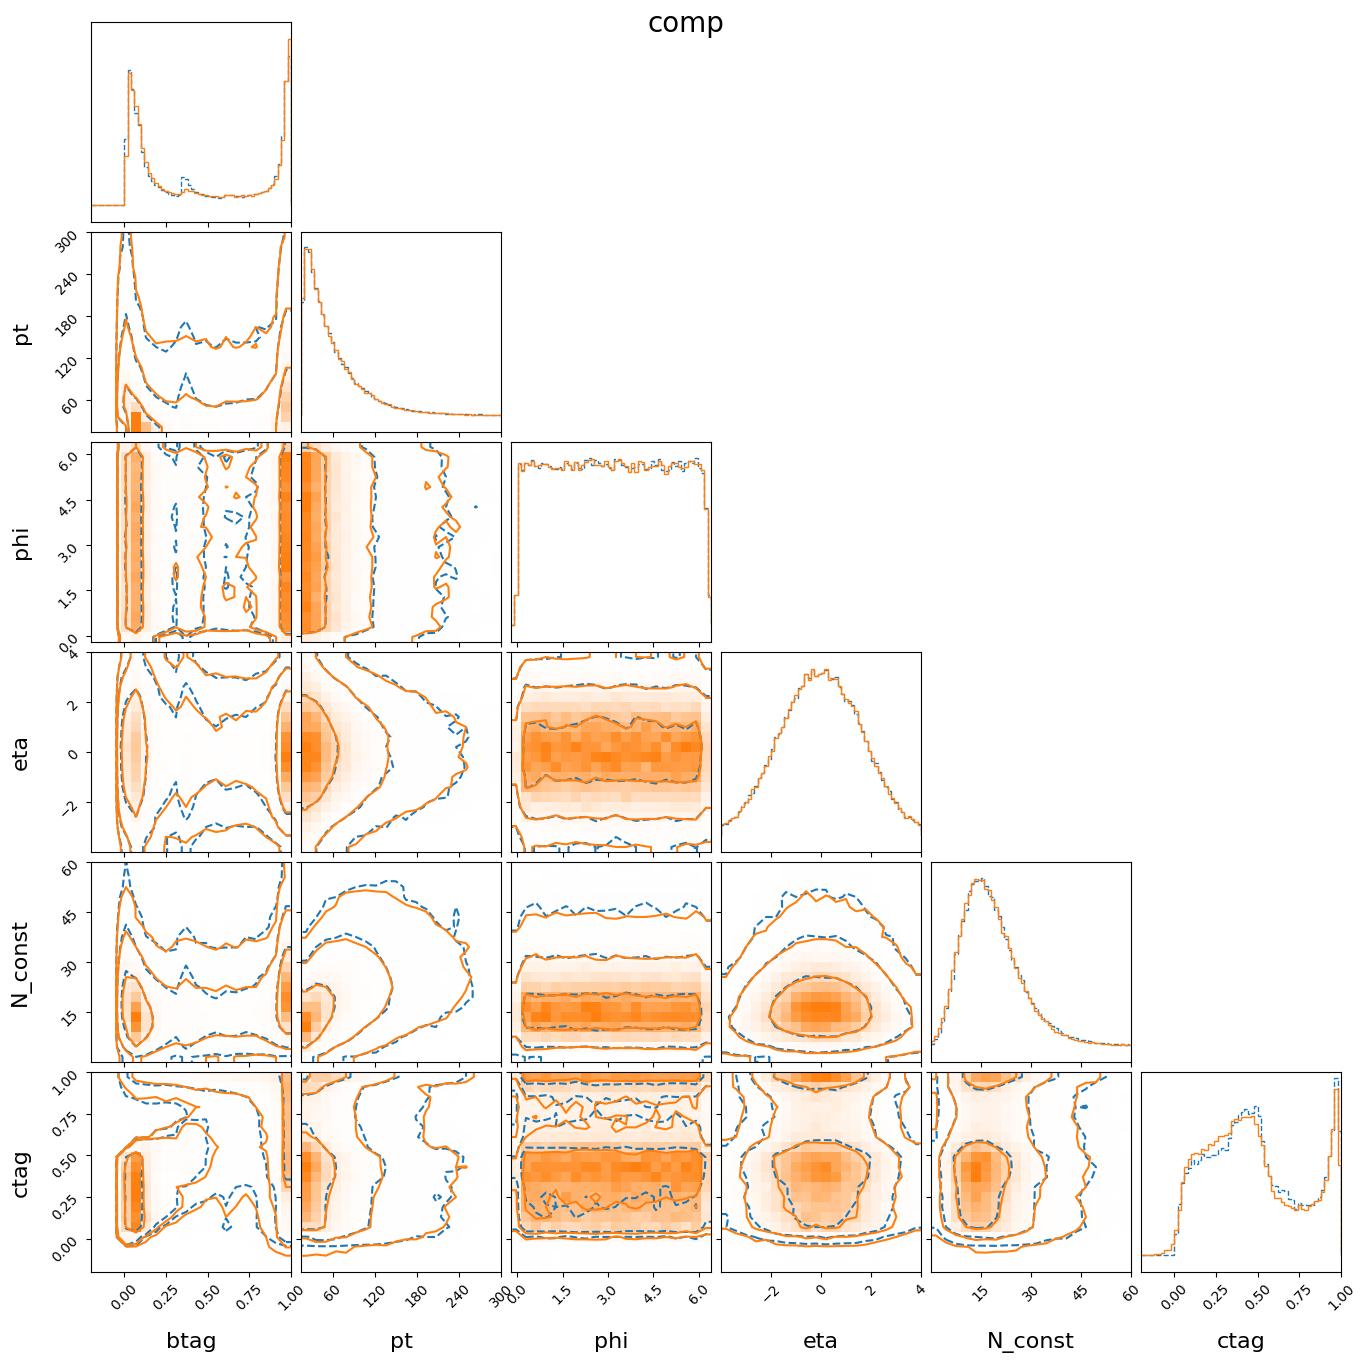

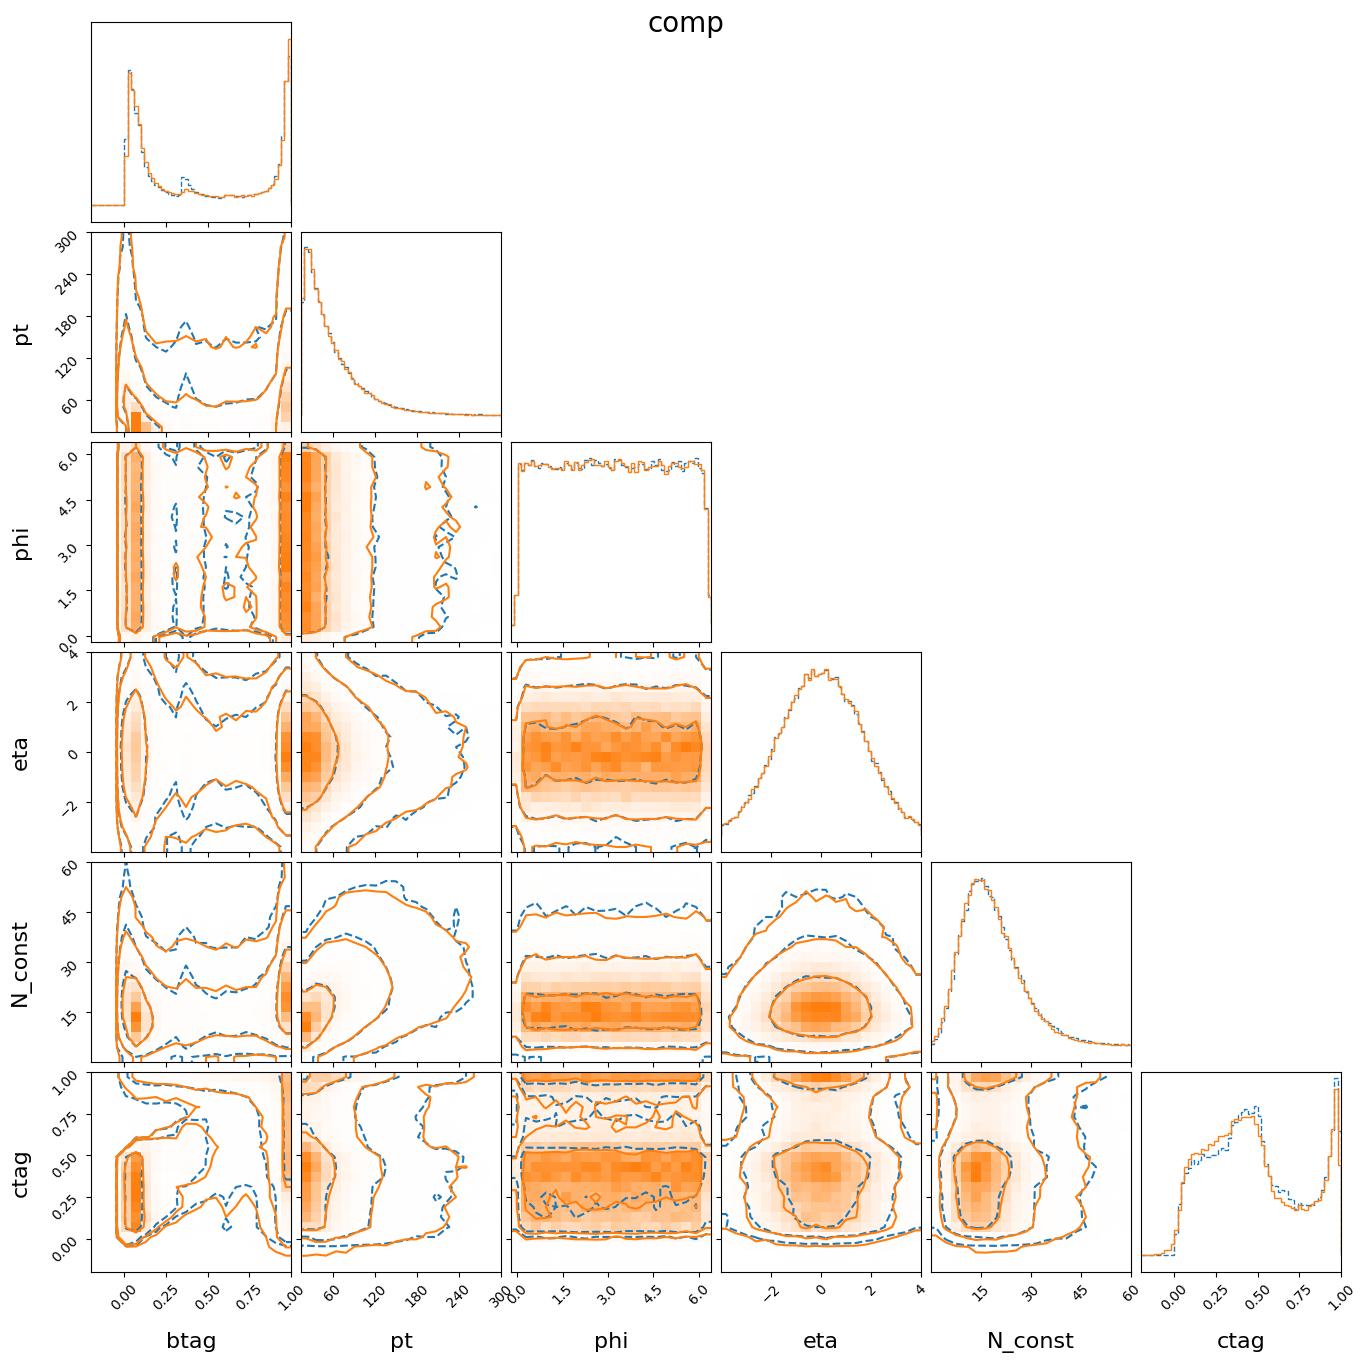

In [19]:
make_corner(reco_val_phys, samples, reco_features, "comp")

We finish this section by evaluating the model on the ROC curves. Here, the agreement is less than what we would like, this is due to the complexity of the conditioning $p(x|g)$ that we are trying to model. A larger network, more training epochs or data or other transformation could result in a better performance.

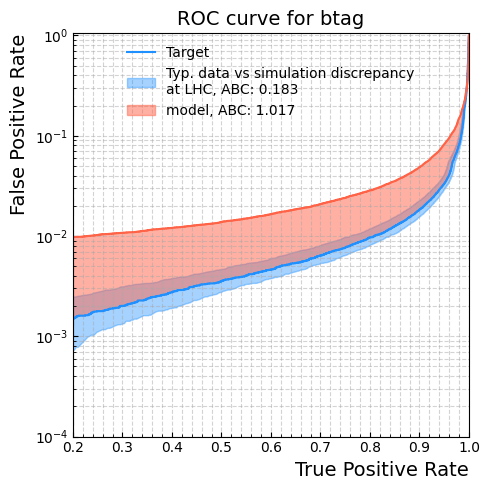

In [20]:
btag = roc_curve_figure(reco_val, gen_val, model=samples, mode='btag')

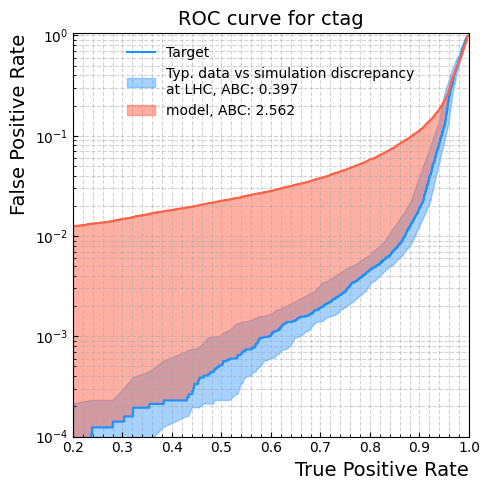

In [21]:
ctag = roc_curve_figure(reco_val, gen_val, model=samples, mode='ctag')

#### Conclusions

Thanks to their explicit handling of pdfs, NF models are very effective for simulating low-dimensional data with high accuracy.

### Generative Adversarial Networks

Generative Adversarial Networks (GAN) [[1][1]] are a powerful class of _generative models_ based on the simultaneous training of two neural networks:

*  **Discriminator network** ($D$) - trained by a classification task to separate the generator output from the reference dataset
* **Generator network** ($G$) - trained by a simulation task to reproduce the reference dataset trying to fake the discriminator

The goal is that $D$ optimally discriminates on the origin of the two samples, and simultaneously the training procedure for $G$ is to maximize the _probability_ of $D$ making a mistake. This framework corresponds to a **minimax two-player game** [[1][1]].

[1]: https://arxiv.org/abs/1406.2661

<div align="center">
  <img src="https://raw.githubusercontent.com/mbarbetti/pidgan-notebooks/main/.github/images/gan-scheme.png" width="800"/>
</div>

##### Additional details

Traditional GAN systems suffer from many issues, particularly during the training phase:

* the generator may _collapse_ producing only a single sample or a small family of very similar samples (**mode collapse**)
* the two players may _oscillate_ during training rather than converging to the [**Nash equilibrium**](https://en.wikipedia.org/wiki/Nash_equilibrium)
* if _imbalance_ between the two players occurs, then the system is incapable of learning at all

All these drawbacks result from the [**vanishing gradient problem**](https://en.wikipedia.org/wiki/Vanishing_gradient_problem), namely the lack of information for the update of the $G$ parameters. This is due to the saturation of the $D$ that is so good in distinguishing the origin of the two samples that no errors remain to the $G$ to improve the generated space [[2][2]]. To fix such problem, the typical solution proposed by the literature is to change the loss function that drive the training procedure [[3][3], [4][4]], to force the smoothness of the discriminator response to the classification task [[5][5], [6][6], [7][7]], or to adoopt a set of strategies in the architecture of the two players [[8][8]]. If you are curious, you can checkout [pidgan](https://github.com/mbarbetti/pidgan), a Python package designed to simplify the provisioning of GAN-based models to flash-simulate the LHCb experiment, which implements all sorts of GAN varietes.

In the following we try to regularize training with two modifications to the original architecture:
 1. We *clip* the parameters of the discriminator in a specific range, to enforce lipschitzianity (WGAN);
 2. We train the discriminator 5 epochs for each epoch of the generator, to try to balance the two networks capabilities.

[2]: https://arxiv.org/abs/1701.04862
[3]: https://arxiv.org/abs/1611.04076
[4]: https://arxiv.org/abs/1701.07875
[5]: https://arxiv.org/abs/1704.00028
[6]: https://arxiv.org/abs/1705.10743
[7]: https://arxiv.org/abs/1907.05681
[8]: https://arxiv.org/abs/1606.03498
[9]: https://arxiv.org/abs/1411.1784

The code defines two classes: `Generator` and `Discriminator`, which are implemented as neural networks using PyTorch's `nn.Module`. Both networks use a series of linear layers followed by LeakyReLU activation functions. The generator takes the latent space and additional data as input, while the discriminator takes the real or generated samples as input.

The `train_wgan` function is responsible for training the WGAN model. It takes the generator, discriminator, and various hyperparameters as input. The training process involves alternating between training the discriminator (critic) and the generator. The discriminator is trained for a specified number of iterations (`critic_iterations`) for each batch of real and generated samples. The generator is trained once per batch.

During the discriminator training, the weights are clipped to enforce the Lipschitz constraint, which is a requirement for WGANs. The loss for the discriminator is calculated as the difference between the average discriminator output for fake samples and real samples.

The generator loss is calculated as the negative of the average discriminator output for fake samples. The generator is updated based on this loss, aiming to generate samples that the discriminator classifies as real.

The training progress is tracked by storing the discriminator and generator losses for each epoch. The validation losses are also calculated using a separate validation set.


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim

# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, output_dim),
            # nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

# Discriminator (Critic)
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

# WGAN Training
def train_wgan(generator, discriminator, latent_dim, real_data, gen_data, real_data_val, gen_data_val, num_epochs, batch_size, lr, critic_iterations):
    optimizer_G = optim.Adam(generator.parameters(), lr=lr)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

    discriminator_loss = []
    discriminator_loss_val = []
    generator_loss = []
    generator_loss_val = []

    for epoch in range(num_epochs):
        discriminator.train()
        generator.train()

        discriminator_loss_epoch = 0
        for _ in range(critic_iterations):
            for batch_idx in range(len(real_data) // batch_size):
                # Train the discriminator
                real_samples = real_data[batch_idx * batch_size: (batch_idx + 1) * batch_size]
                latent_samples = torch.randn(len(real_samples), latent_dim).to(device)
                gen_samples = gen_data[batch_idx * batch_size: (batch_idx + 1) * batch_size]
                fake_samples = generator(torch.cat((latent_samples, gen_samples), dim=1).to(device))

                discriminator_real = discriminator(torch.cat((real_samples, gen_samples), dim=1))
                discriminator_fake = discriminator(torch.cat((fake_samples, gen_samples), dim=1))

                loss_D = torch.mean(discriminator_fake) - torch.mean(discriminator_real)
                discriminator_loss_epoch += loss_D.item()
                optimizer_D.zero_grad()
                loss_D.backward()
                optimizer_D.step()

                # Clip discriminator weights to enforce Lipschitz constraint (WGAN)
                for p in discriminator.parameters():
                    p.data.clamp_(-0.01, 0.01)

        discriminator_loss.append(discriminator_loss_epoch / (critic_iterations * len(real_data) // batch_size))

        with torch.no_grad():
            fake_val_samples = generator(torch.cat((torch.randn(len(real_data_val), latent_dim).to(device), gen_data_val), dim=1)).to(device)
            val_loss_D = torch.mean(discriminator(torch.cat((fake_val_samples, gen_data_val), dim=1))) - torch.mean(discriminator(torch.cat((real_data_val, gen_data_val), dim=1)))
            val_loss_D = torch.mean(val_loss_D).cpu().numpy()
        
        discriminator_loss_val.append(val_loss_D)

        # Train the generator
        generator_loss_epoch = 0
        for batch_idx in range(len(real_data) // batch_size):
            gen_samples = gen_data[batch_idx * batch_size: (batch_idx + 1) * batch_size]
            latent_samples = torch.randn(len(gen_samples), latent_dim).to(device)
            fake_samples = generator(torch.cat((latent_samples, gen_samples), dim=1).to(device))
            discriminator_fake = discriminator(torch.cat((fake_samples, gen_samples), dim=1))

            loss_G = -torch.mean(discriminator_fake)
            optimizer_G.zero_grad()
            loss_G.backward()
            optimizer_G.step()
            generator_loss_epoch += loss_G.item()

        generator_loss.append(generator_loss_epoch / (len(real_data) // batch_size))


        with torch.no_grad():
            fake_val_samples = generator(torch.cat((torch.randn(len(real_data_val), latent_dim).to(device), gen_data_val), dim=1)).to(device)
            val_loss_G = -torch.mean(discriminator(torch.cat((fake_val_samples, gen_data_val), dim=1)))

        generator_loss_val.append((val_loss_G / (len(real_data) // batch_size)).cpu().numpy())

        # Print training progress
        print(f"Epoch [{epoch+1}/{num_epochs}], Discriminator Loss: {discriminator_loss[-1]:.4f}, Generator Loss: {generator_loss[-1]:.4f}")

    return discriminator_loss, generator_loss, discriminator_loss_val, generator_loss_val



In [23]:
# Example usage
latent_dim = 6
output_dim = 6

# the generator takes the latent space and the gen data as input
generator = Generator(latent_dim*2, output_dim).to(device)
discriminator = Discriminator(output_dim*2).to(device)

In [24]:
# torchsummary of models

print(summary(generator, (latent_dim*2,)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             416
         LeakyReLU-2                   [-1, 32]               0
            Linear-3                   [-1, 64]           2,112
         LeakyReLU-4                   [-1, 64]               0
            Linear-5                  [-1, 128]           8,320
         LeakyReLU-6                  [-1, 128]               0
            Linear-7                  [-1, 128]          16,512
         LeakyReLU-8                  [-1, 128]               0
            Linear-9                    [-1, 6]             774
Total params: 28,134
Trainable params: 28,134
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.11
Estimated Total Size (MB): 0.11
---------------------------------------------

In [25]:
print(summary(discriminator, (output_dim*2,)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             416
         LeakyReLU-2                   [-1, 32]               0
            Linear-3                   [-1, 64]           2,112
         LeakyReLU-4                   [-1, 64]               0
            Linear-5                  [-1, 128]           8,320
         LeakyReLU-6                  [-1, 128]               0
            Linear-7                  [-1, 128]          16,512
         LeakyReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 64]           8,256
        LeakyReLU-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 35,681
Trainable params: 35,681
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [26]:
num_epochs = 50
batch_size = 1280
lr = 0.0001
critic_iterations = 5

discriminator_loss, generator_loss, discriminator_loss_val, generator_loss_val = train_wgan(generator, discriminator, latent_dim, reco_train_torch, gen_train_torch, reco_val_torch, gen_val_torch, num_epochs, batch_size, lr, critic_iterations)

Epoch [1/50], Discriminator Loss: -0.0000, Generator Loss: 0.0099
Epoch [2/50], Discriminator Loss: -0.0021, Generator Loss: -0.0223


Epoch [3/50], Discriminator Loss: -0.1676, Generator Loss: 0.0804
Epoch [4/50], Discriminator Loss: -0.0300, Generator Loss: 0.0234
Epoch [5/50], Discriminator Loss: -0.0162, Generator Loss: 0.0072
Epoch [6/50], Discriminator Loss: -0.0017, Generator Loss: 0.0082
Epoch [7/50], Discriminator Loss: -0.0095, Generator Loss: 0.0030
Epoch [8/50], Discriminator Loss: -0.0009, Generator Loss: 0.0076
Epoch [9/50], Discriminator Loss: -0.0164, Generator Loss: 0.0094
Epoch [10/50], Discriminator Loss: 0.0001, Generator Loss: 0.0051
Epoch [11/50], Discriminator Loss: -0.0019, Generator Loss: -0.1457
Epoch [12/50], Discriminator Loss: 0.0035, Generator Loss: 0.0096
Epoch [13/50], Discriminator Loss: 0.0000, Generator Loss: 0.0096
Epoch [14/50], Discriminator Loss: 0.0000, Generator Loss: 0.0096
Epoch [15/50], Discriminator Loss: 0.0000, Generator Loss: 0.0096
Epoch [16/50], Discriminator Loss: -0.3065, Generator Loss: 0.1734
Epoch [17/50], Discriminator Loss: -0.0539, Generator Loss: 0.0115
Epoch 

We can see that the training of the two agents is still unstable, despite the precautions we took when defining the training regime.

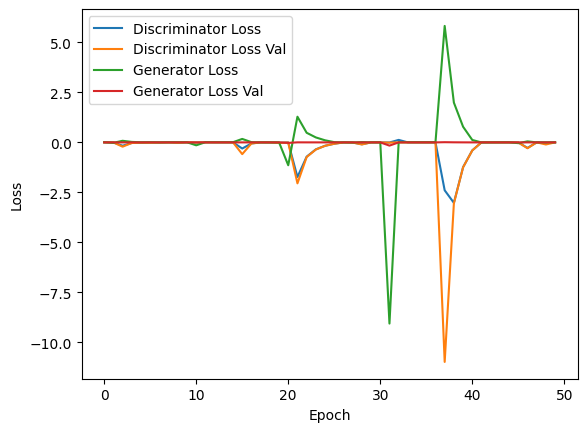

In [27]:
# plot the losses
plt.plot(discriminator_loss[:], label='Discriminator Loss')
plt.plot(discriminator_loss_val[:], label='Discriminator Loss Val')
plt.plot(generator_loss[:], label='Generator Loss')
plt.plot(generator_loss_val[:], label='Generator Loss Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


If we sample and check the results, we can see that they are well below the accuracy we need!

In [28]:
# Generate samples from the trained generator
latent_samples = torch.randn(len(reco_val), latent_dim).to(device)
# gen_samples = torch.tensor(gen_val, dtype=torch.float32).to(device)

fake_samples = generator(torch.cat((latent_samples, gen_val_torch), dim=1).to(device)).detach().cpu().numpy()
# postprocess the generated samples
fake_samples, _ = preprocessor.invert(fake_samples, gen_val)

/home/users/fvaselli/iCSC/utils.py:31: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[i, 1].set_yscale('log')


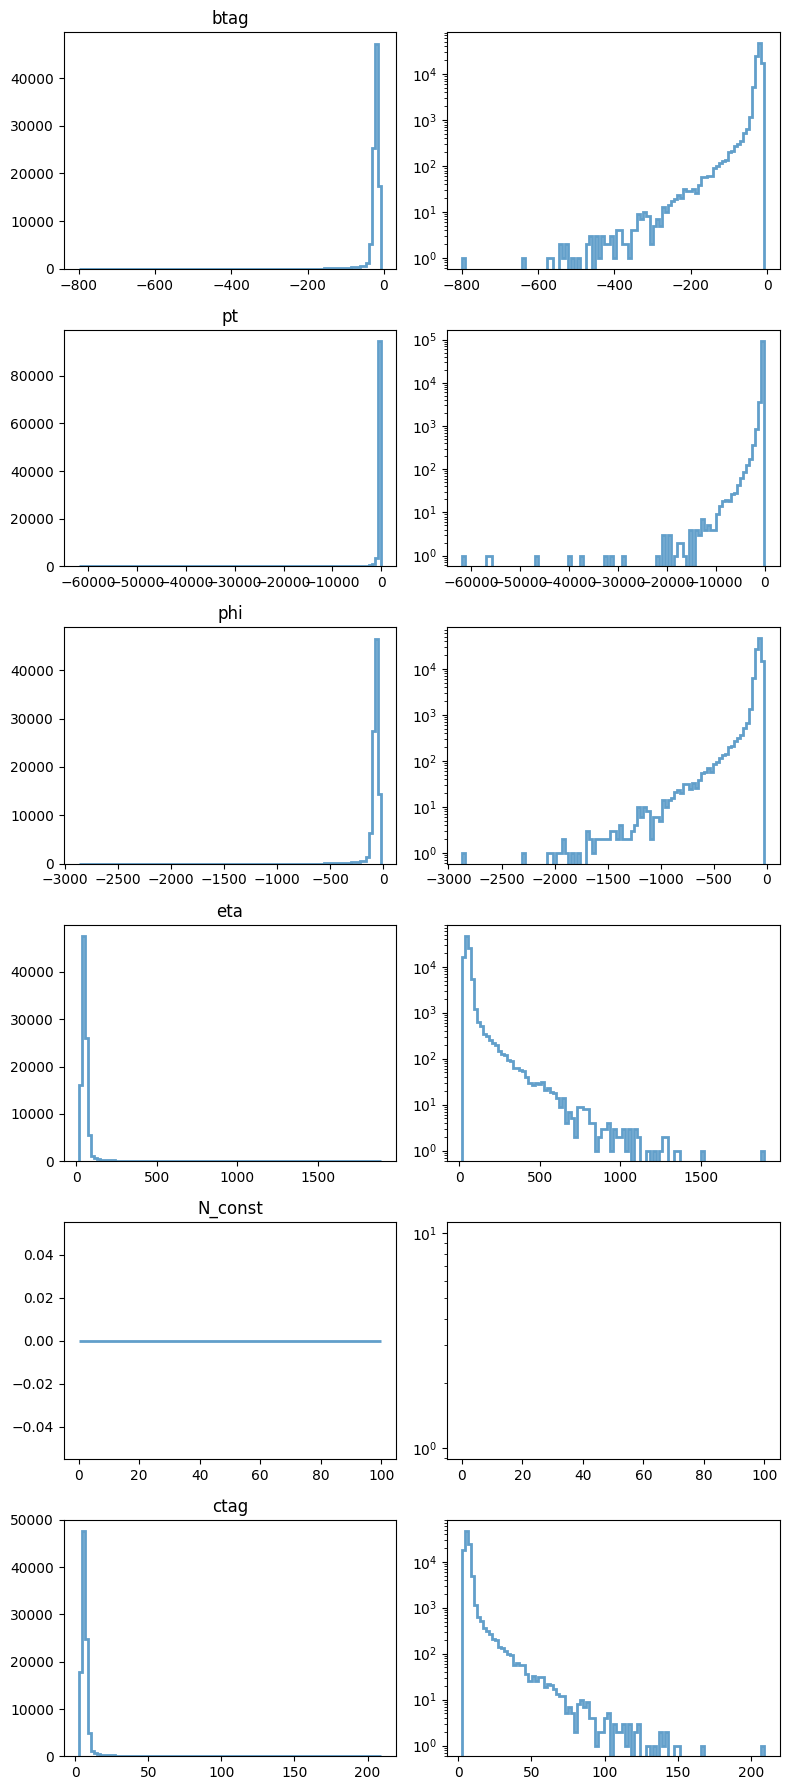

In [29]:
plot_1dhistos(fake_samples, reco_features)

/home/users/fvaselli/iCSC/utils.py:342: RuntimeWarning: invalid value encountered in divide
  (np.sqrt(hist_flash) / hist_flash) ** 2 + (np.sqrt(hist_reco) / hist_reco) ** 2
/home/users/fvaselli/iCSC/utils.py:344: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio_err * (hist_flash / hist_reco)
/home/users/fvaselli/iCSC/utils.py:345: RuntimeWarning: invalid value encountered in divide
  ratio = hist_flash / hist_reco


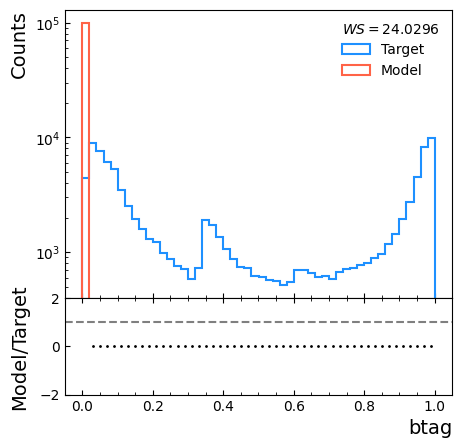

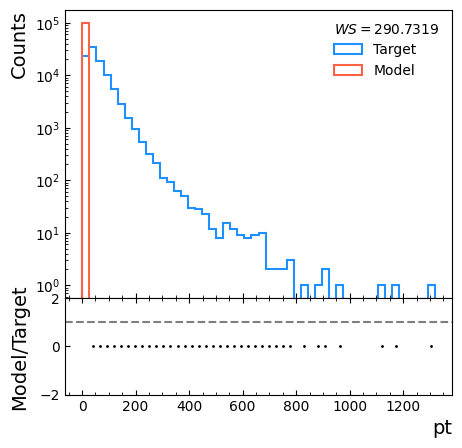

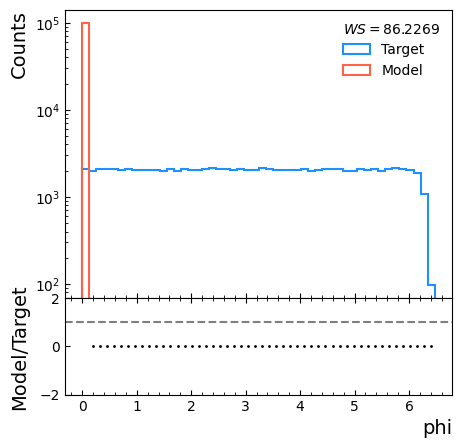

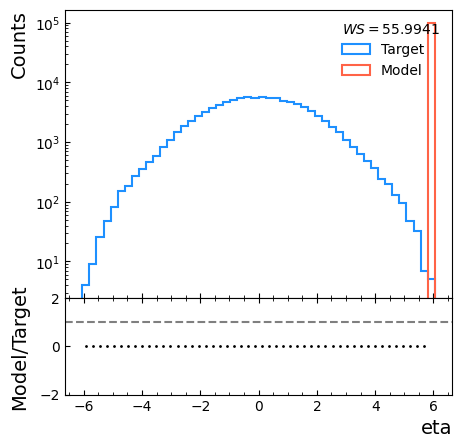

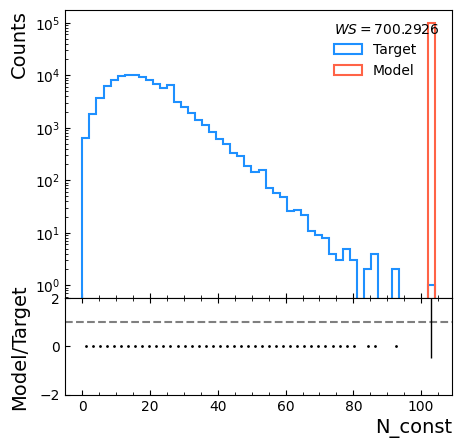

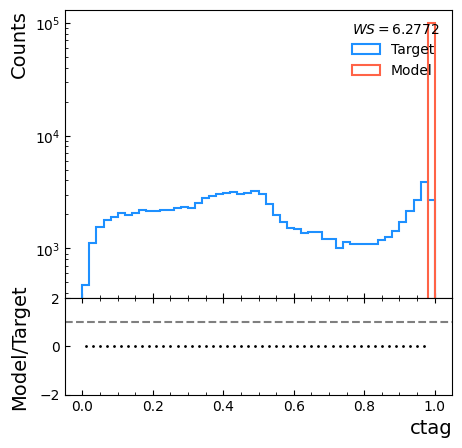

In [30]:
# plot the generated data

# reco_val_post = preprocessor.invert(reco_val, gen_val)[0]

for i in range(6):
    plot_1d_hist(fake_samples[:, i], reco_val_post[:, i], label=reco_features[i], title=f'Generated vs Real {reco_features[i]}', bins=50, logScale=True)

Because of it's instabilities during training, GANs struggle with reproducing the training data. This is also due to the fact that GANs were not introduced to work in low-dimensional settings such as our case, but rather in high-dimensional data spaces such as images, where high accuracy on the single pixel is not required.

### Variational Autoencoder

The code defines a Variational Autoencoder (VAE) [[1][1]] model for generating and reconstructing data. A VAE is a generative model that learns a latent representation of the input data and can generate new samples from the learned latent space.

The VAE consists of two main components: an encoder and a decoder. The encoder maps the input data to a latent space, while the decoder reconstructs the input data from the latent representation.

The loss function used in the VAE is a combination of the reconstruction loss and the Kullback-Leibler (KL) divergence loss. The reconstruction loss measures the difference between the reconstructed data and the original input data, while the KL divergence loss encourages the latent space to follow a prior distribution, typically a standard normal distribution.

The loss function can be written as:

$\mathcal{L} = \mathcal{L}_{recon} + \mathcal{L}_{KL}$

where $\mathcal{L}_{recon}$ is the reconstruction loss (e.g., mean squared error) and $\mathcal{L}_{KL}$ is the KL divergence loss.

The KL divergence loss is given by:

$\mathcal{L}_{KL} = -\frac{1}{2} \sum_{i=1}^{N} (1 + \log(\sigma_i^2) - \mu_i^2 - \sigma_i^2)$

where $\mu_i$ and $\sigma_i$ are the mean and standard deviation of the latent variable for the $i$-th dimension, and $N$ is the dimensionality of the latent space.

<div align="center">
  <img src="https://lilianweng.github.io/posts/2018-08-12-vae/vae-gaussian.png" width="800"/>
</div>


The provided code defines the following components:

1. `Encoder`: A neural network module that maps the input data to the latent space. It takes the input data and a generator input, passes them through fully connected layers with ReLU activations, and outputs the mean and log-variance of the latent distribution.

2. `Decoder`: A neural network module that reconstructs the input data from the latent representation. It takes the latent variable and the generator input, passes them through fully connected layers with ReLU activations, and outputs the reconstructed data.

3. `VAE`: The main VAE model that combines the encoder and decoder. It defines the forward pass, which includes encoding the input data, sampling from the latent distribution using the reparameterization trick, and decoding the latent variable to reconstruct the input data.

4. `train_vae`: A function that trains the VAE model using the provided data. It iterates over the training data in batches, computes the reconstruction loss and KL divergence loss, and updates the model parameters using an optimizer. It also evaluates the model on validation data and prints the loss for each epoch.

[1]: https://lilianweng.github.io/posts/2018-08-12-vae/

In [41]:
### VAE

import torch
import torch.nn as nn
import torch.optim as optim

# Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, n_layers):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_gen = nn.Linear(input_dim, hidden_dim)
        self.fc_tot = nn.Linear(hidden_dim*2, hidden_dim)
        
        self.hidden = nn.ModuleList()
        for _ in range(n_layers):
           self.hidden.append(nn.Linear(hidden_dim, hidden_dim))
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x, gen):
        h = self.relu(self.fc1(x))
        h_gen = self.relu(self.fc_gen(gen))
        h = torch.cat((h, h_gen), dim=1)
        h = self.relu(self.fc_tot(h))
        for layer in self.hidden:
            h = self.relu(layer(h))
        return self.fc21(h), self.fc22(h)

# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, n_layers):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_gen = nn.Linear(output_dim, hidden_dim)
        self.fc_tot = nn.Linear(hidden_dim*2, hidden_dim)

        self.hidden = nn.ModuleList()
        for _ in range(n_layers):
              self.hidden.append(nn.Linear(hidden_dim, hidden_dim))
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, z, gen):
        h = self.relu(self.fc1(z))
        h_gen = self.relu(self.fc_gen(gen))
        h = torch.cat((h, h_gen), dim=1)
        h = self.relu(self.fc_tot(h))
        for layer in self.hidden:
            h = self.relu(layer(h))
        return self.fc3(h)

# VAE
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, n_layers):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim, n_layers)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim, n_layers)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, gen):
        mu, log_var = self.encoder(x, gen)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decoder(z, gen)
        return x_recon, mu, log_var
    
    def sample(self, gen):
        z = torch.randn(len(gen), self.latent_dim).to(device)
        return self.decoder(z, gen)

# VAE Training
def train_vae(vae, reco, gen, reco_val, gen_val, num_epochs, batch_size, lr):
    optimizer = optim.Adam(vae.parameters(), lr=lr)
    loss_train = []
    loss_val = []

    for epoch in range(num_epochs):
        loss_epoch = 0
        for batch_idx in range(len(reco) // batch_size):
            batch = reco[batch_idx * batch_size: (batch_idx + 1) * batch_size]
            batch_gen = gen[batch_idx * batch_size: (batch_idx + 1) * batch_size]
            x_recon, mu, log_var = vae(batch, batch_gen)
            recon_loss = nn.MSELoss()(x_recon, batch)
            kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = recon_loss + kl_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss.item()

        loss_train.append(loss_epoch / (len(reco) // batch_size))
    
        with torch.no_grad():
            x_recon_val, mu_val, log_var_val = vae(reco_val, gen_val)
            recon_loss_val = nn.MSELoss()(x_recon_val, reco_val)
            kl_loss_val = -0.5 * torch.sum(1 + log_var_val - mu_val.pow(2) - log_var_val.exp())
            loss_val_num = recon_loss_val + kl_loss_val

            loss_val.append(loss_val_num.item())
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss_train[-1]:.4f}, Val Loss: {loss_val[-1]:.4f}")
    
    return loss_train, loss_val

We can initialize the model and plot its layers as follows:

In [42]:
vae = VAE(input_dim=6, hidden_dim=64, latent_dim=2, n_layers=4).to(device)
print(summary(vae, [(6,),(6,)]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             448
              ReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 64]             448
              ReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 64]           8,256
              ReLU-6                   [-1, 64]               0
            Linear-7                   [-1, 64]           4,160
              ReLU-8                   [-1, 64]               0
            Linear-9                   [-1, 64]           4,160
             ReLU-10                   [-1, 64]               0
           Linear-11                   [-1, 64]           4,160
             ReLU-12                   [-1, 64]               0
           Linear-13                   [-1, 64]           4,160
             ReLU-14                   

In [43]:
num_epochs = 50
batch_size = 128
lr = 0.001


loss_train, loss_val = train_vae(vae, reco_train_torch, gen_train_torch, reco_val_torch, gen_val_torch, num_epochs, batch_size, lr)


Epoch [1/50], Loss: 0.2283, Val Loss: 0.2224
Epoch [2/50], Loss: 0.2130, Val Loss: 0.2144
Epoch [3/50], Loss: 0.2121, Val Loss: 0.2134
Epoch [4/50], Loss: 0.2117, Val Loss: 0.2212
Epoch [5/50], Loss: 0.2113, Val Loss: 0.2138
Epoch [6/50], Loss: 0.2111, Val Loss: 0.2133
Epoch [7/50], Loss: 0.2110, Val Loss: 0.2131
Epoch [8/50], Loss: 0.2108, Val Loss: 0.2135
Epoch [9/50], Loss: 0.2108, Val Loss: 0.2122
Epoch [10/50], Loss: 0.2106, Val Loss: 0.2138
Epoch [11/50], Loss: 0.2106, Val Loss: 0.2122
Epoch [12/50], Loss: 0.2106, Val Loss: 0.2130
Epoch [13/50], Loss: 0.2105, Val Loss: 0.2120
Epoch [14/50], Loss: 0.2104, Val Loss: 0.2169
Epoch [15/50], Loss: 0.2104, Val Loss: 0.2119
Epoch [16/50], Loss: 0.2104, Val Loss: 0.2129
Epoch [17/50], Loss: 0.2103, Val Loss: 0.2127
Epoch [18/50], Loss: 0.2105, Val Loss: 0.2126
Epoch [19/50], Loss: 0.2103, Val Loss: 0.2122
Epoch [20/50], Loss: 0.2103, Val Loss: 0.2113
Epoch [21/50], Loss: 0.2102, Val Loss: 0.2138
Epoch [22/50], Loss: 0.2103, Val Loss: 0.21

We plot the loss curves below:

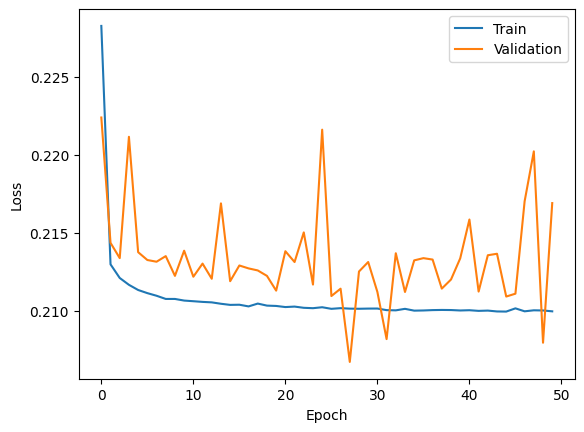

In [44]:
plt.plot(loss_train[:], label='Train')
plt.plot(loss_val[:], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

And we can generate new data as follows. Unfortunatley, the performance is not accurate enough (even if there are improvements compared to GANs). This could be due to various factors, including:
- Too few parameters in our models;
- Models not defined to work in small-dimensional settings;
- Gaussian approximations in the latent space disrupting the latent representation.

/home/users/fvaselli/iCSC/utils.py:342: RuntimeWarning: invalid value encountered in divide
  (np.sqrt(hist_flash) / hist_flash) ** 2 + (np.sqrt(hist_reco) / hist_reco) ** 2
/home/users/fvaselli/iCSC/utils.py:344: RuntimeWarning: divide by zero encountered in divide
  ratio_err = ratio_err * (hist_flash / hist_reco)
/home/users/fvaselli/iCSC/utils.py:344: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio_err * (hist_flash / hist_reco)
/home/users/fvaselli/iCSC/utils.py:345: RuntimeWarning: divide by zero encountered in divide
  ratio = hist_flash / hist_reco
/home/users/fvaselli/iCSC/utils.py:345: RuntimeWarning: invalid value encountered in divide
  ratio = hist_flash / hist_reco


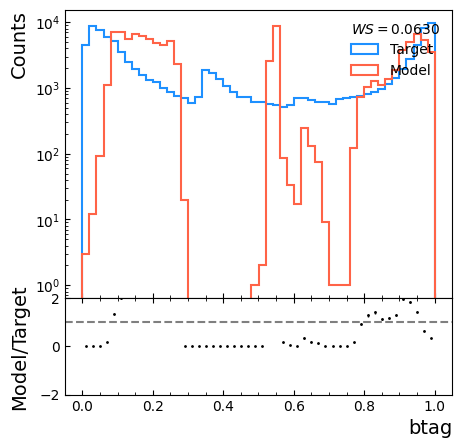

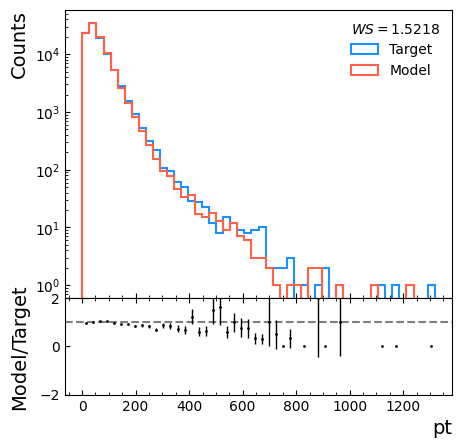

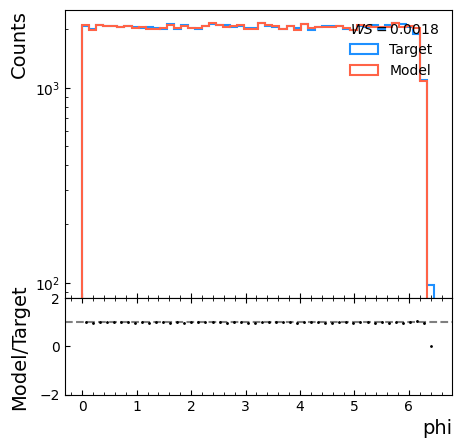

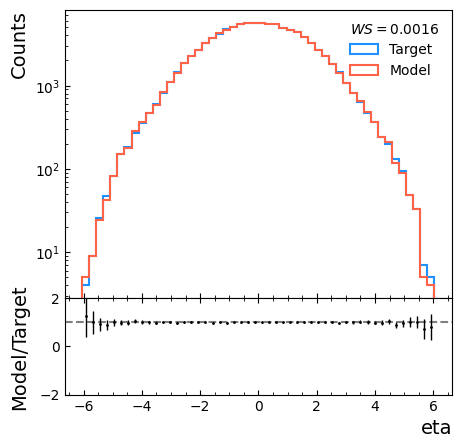

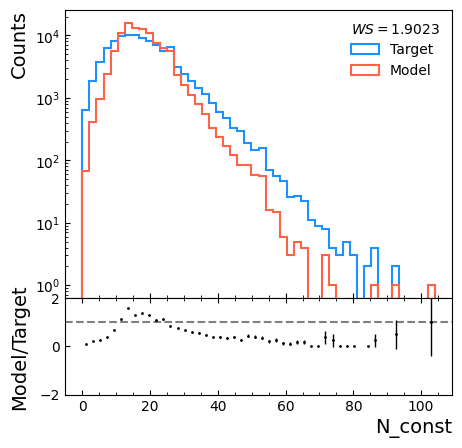

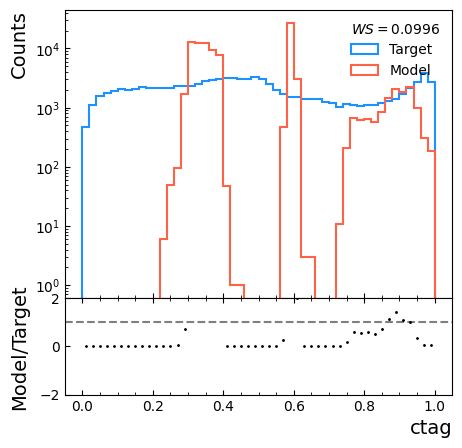

In [45]:
# generate
with torch.no_grad():
    x_recon = vae.sample(gen_val_torch).cpu().numpy()
    x_recon, _ = preprocessor.invert(x_recon, gen_val)
    reco_val_phys, _ = preprocessor.invert(reco_val, gen_val)


for i in range(6):
    plot_1d_hist(x_recon[:, i], reco_val_phys[:, i], label=reco_features[i], title=f'Reconstructed vs Real {reco_features[i]}', bins=50, logScale=True)

### Diffusion Model

The code defines a Conditional Diffusion Model, which is a type of generative model used for tasks such as image generation or denoising. The model learns to generate samples by iteratively denoising a noisy input conditioned on a given variable. The reference paper is [["Denoising Diffusion Probabilistic Models
"][1]].

The `ConditionalDiffusionModel` class defines the architecture of the model. It consists of a series of fully connected layers with ReLU activations. The input to the model is a concatenation of the input features, time step, and conditioning variable. The model predicts the noise that was added to the input at a specific time step.

The `train` function defines the training loop for the Conditional Diffusion Model. The training process involves the following steps:

1. For each batch of data:
   - Sample a random time step for each data point.
   - Compute the noise schedule based on the beta values.
   - Sample noise and compute the noisy input by adding the noise to the original data.
   - Predict the noise using the model, conditioned on the noisy input, time step, and conditioning variable.
   - Compute the loss between the predicted noise and the actual noise using the Mean Squared Error (MSE) loss.
   - Backpropagate the gradients and update the model parameters.

2. Validate the model on a validation set:
   - Sample a random time step for each data point in the validation set.
   - Compute the noise schedule and add noise to the validation data.
   - Predict the noise using the model and compute the validation loss.

3. Print the training and validation losses for each step.

The loss function used in this model is the Mean Squared Error (MSE) loss, which measures the average squared difference between the predicted noise and the actual noise. The formula for MSE loss is:

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

where $y_i$ is the actual noise and $\hat{y}_i$ is the predicted noise for the $i$-th sample, and $n$ is the total number of samples.

<div align="center">
  <img src="https://hojonathanho.github.io/diffusion/assets/img/pgm_diagram_xarrow.png" width="800"/>
</div>


<div align="center">
  <img src="https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM-algo.png" width="800"/>
</div>

[1]: https://arxiv.org/abs/2006.11239


In [46]:
import torch
import torch.nn as nn
import torch.optim as optim


# Define the diffusion model
class ConditionalDiffusionModel(nn.Module):
    def __init__(self, input_dim, cond_dim, hidden_dim, num_layers):
        super(ConditionalDiffusionModel, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim + cond_dim +1, 32))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(32, hidden_dim))
        layers.append(nn.ReLU())
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, 32))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(32, input_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x, t, c):
        # Concatenate the input features, time step, and conditioning variable
        x = torch.cat([x, t.reshape(-1, 1), c], dim=1)
        return self.model(x)

# Define the training loop
def train(model, reco, gen, reco_val, gen_val , epochs, num_steps, beta_start, beta_end, batch_size, lr):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    loss_train = []
    loss_val = []

    for step in range(epochs):
        loss_epoch = 0

        for batch_idx in range(len(reco) // batch_size):
            reco_batch = reco[batch_idx * batch_size: (batch_idx + 1) * batch_size]
            gen_batch = gen[batch_idx * batch_size: (batch_idx + 1) * batch_size]

            # Sample a random time step for each data point
            t = torch.rand(reco_batch.shape[0], device=device) * (num_steps - 1)
            t = t.long()

            # Compute the noise schedule
            beta = torch.linspace(beta_start, beta_end, num_steps, device=device)
            alpha = 1 - beta
            alpha_bar = torch.cumprod(alpha, dim=0)

            # Sample noise and compute the noisy input
            noise = torch.randn_like(reco_batch)
            noisy_data = torch.sqrt(alpha_bar[t]).view(-1, 1) * reco_batch + torch.sqrt(1 - alpha_bar[t]).view(-1, 1) * noise

            # Predict the noise and compute the loss
            predicted_noise = model(noisy_data, t, gen_batch)
            loss = criterion(predicted_noise, noise)

            # Backpropagate and update the model parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss.item()

        loss_train.append(loss_epoch / (len(reco) // batch_size))

        # validate
        with torch.no_grad():
            t_val = torch.rand(reco_val.shape[0], device=device) * (num_steps - 1)
            t_val = t_val.long()

            beta_val = torch.linspace(beta_start, beta_end, num_steps, device=device)
            alpha_val = 1 - beta_val
            alpha_bar_val = torch.cumprod(alpha_val, dim=0)

            noise_val = torch.randn_like(reco_val)
            noisy_data_val = torch.sqrt(alpha_bar_val[t_val]).view(-1, 1) * reco_val + torch.sqrt(1 - alpha_bar_val[t_val]).view(-1, 1) * noise_val

            predicted_noise_val = model(noisy_data_val, t_val, gen_val)
            loss_val_epoch = criterion(predicted_noise_val, noise_val)
        
        loss_val.append(loss_val_epoch.item())

        print(f"Step [{step+1}/{epochs}], Loss: {loss_train[-1]:.4f}, Val Loss: {loss_val[-1]:.4f}")
    
    return loss_train, loss_val

In [49]:
# Set up the device and hyperparameters
input_dim = 6
cond_dim = 6
hidden_dim = 128
num_layers = 5
num_epochs = 200
num_steps = 1000
beta_start = 1e-4
beta_end = 0.02
batch_size = 128
lr = 0.001


# Create the conditional diffusion model and move it to the device
model = ConditionalDiffusionModel(input_dim, cond_dim, hidden_dim, num_layers).to(device)
summary(model, [(6,),(1,),(6,)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             448
              ReLU-2                   [-1, 32]               0
            Linear-3                  [-1, 128]           4,224
              ReLU-4                  [-1, 128]               0
            Linear-5                  [-1, 128]          16,512
              ReLU-6                  [-1, 128]               0
            Linear-7                  [-1, 128]          16,512
              ReLU-8                  [-1, 128]               0
            Linear-9                  [-1, 128]          16,512
             ReLU-10                  [-1, 128]               0
           Linear-11                  [-1, 128]          16,512
             ReLU-12                  [-1, 128]               0
           Linear-13                   [-1, 32]           4,128
             ReLU-14                   

In [50]:
# train
loss_train, loss_val = train(model, reco_train_torch, gen_train_torch, reco_val_torch, gen_val_torch, num_epochs, num_steps, beta_start, beta_end, batch_size, lr)

Step [1/200], Loss: 1.0007, Val Loss: 0.9992
Step [2/200], Loss: 1.0015, Val Loss: 1.0028
Step [3/200], Loss: 1.0005, Val Loss: 1.0027
Step [4/200], Loss: 1.0001, Val Loss: 1.0012
Step [5/200], Loss: 0.9999, Val Loss: 1.0033
Step [6/200], Loss: 0.9982, Val Loss: 1.0035
Step [7/200], Loss: 1.0012, Val Loss: 0.9970
Step [8/200], Loss: 0.9999, Val Loss: 1.0012
Step [9/200], Loss: 1.0011, Val Loss: 1.0013
Step [10/200], Loss: 0.9989, Val Loss: 0.9992
Step [11/200], Loss: 0.9992, Val Loss: 0.9986
Step [12/200], Loss: 1.0007, Val Loss: 1.0005
Step [13/200], Loss: 1.0006, Val Loss: 1.0008
Step [14/200], Loss: 1.0002, Val Loss: 1.0029
Step [15/200], Loss: 0.9998, Val Loss: 1.0021
Step [16/200], Loss: 1.0003, Val Loss: 1.0022
Step [17/200], Loss: 1.0007, Val Loss: 1.0005
Step [18/200], Loss: 0.9991, Val Loss: 0.9960
Step [19/200], Loss: 0.9987, Val Loss: 1.0008
Step [20/200], Loss: 1.0007, Val Loss: 1.0005
Step [21/200], Loss: 0.9996, Val Loss: 0.9991
Step [22/200], Loss: 1.0013, Val Loss: 0.99

The training is quite stable and results are better than VAE, however we are still lacking the desired accuracy.

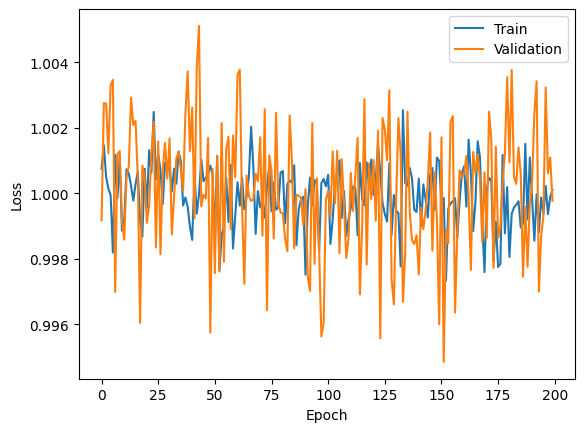

In [52]:
# plot the losses
plt.plot(loss_train[:], label='Train')
plt.plot(loss_val[:], label='Validation')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.legend()

In [53]:
# sample
with torch.no_grad():
    t = torch.rand(len(gen_val_torch), device=device) * (num_steps - 1)
    t = t.long()
    beta = torch.linspace(beta_start, beta_end, num_steps, device=device)
    alpha = 1 - beta
    alpha_bar = torch.cumprod(alpha, dim=0)

    noise = torch.randn_like(reco_val_torch)
    noisy_data = torch.sqrt(alpha_bar[t]).view(-1, 1) * reco_val_torch + torch.sqrt(1 - alpha_bar[t]).view(-1, 1) * noise

    predicted_noise = model(noisy_data, t, gen_val_torch)
    denoised_data = noisy_data - predicted_noise

    denoised_data = denoised_data.cpu().numpy()
    denoised_data, _ = preprocessor.invert(denoised_data, gen_val)
    reco_val_phys, _ = preprocessor.invert(reco_val, gen_val)

/home/users/fvaselli/iCSC/utils.py:342: RuntimeWarning: invalid value encountered in divide
  (np.sqrt(hist_flash) / hist_flash) ** 2 + (np.sqrt(hist_reco) / hist_reco) ** 2
/home/users/fvaselli/iCSC/utils.py:344: RuntimeWarning: divide by zero encountered in divide
  ratio_err = ratio_err * (hist_flash / hist_reco)
/home/users/fvaselli/iCSC/utils.py:344: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio_err * (hist_flash / hist_reco)
/home/users/fvaselli/iCSC/utils.py:345: RuntimeWarning: divide by zero encountered in divide
  ratio = hist_flash / hist_reco
/home/users/fvaselli/iCSC/utils.py:345: RuntimeWarning: invalid value encountered in divide
  ratio = hist_flash / hist_reco


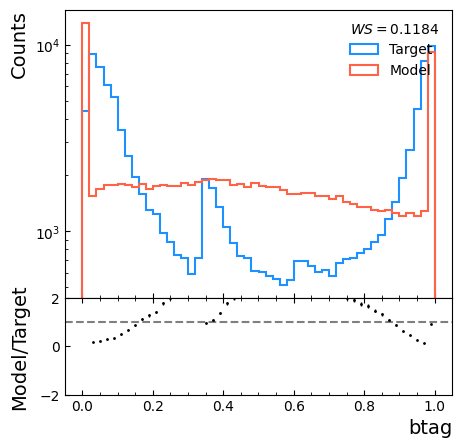

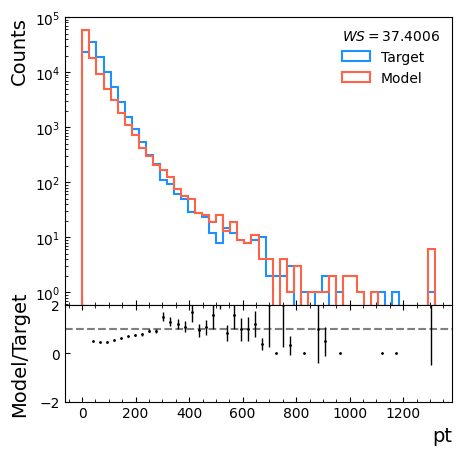

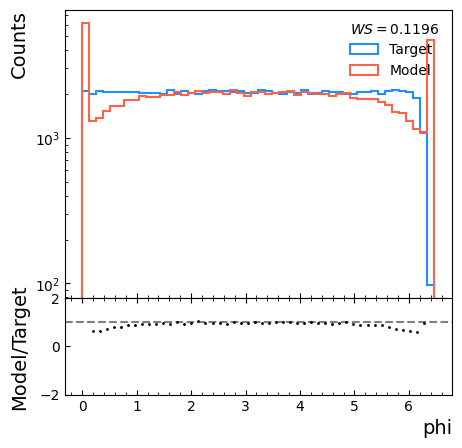

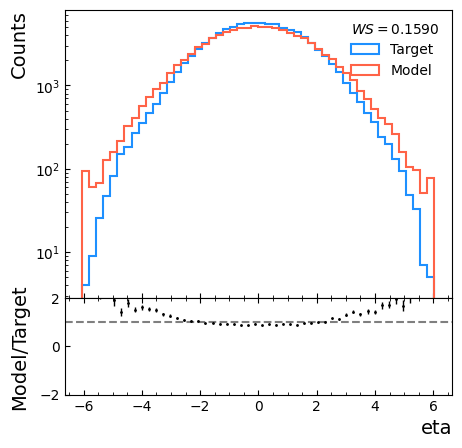

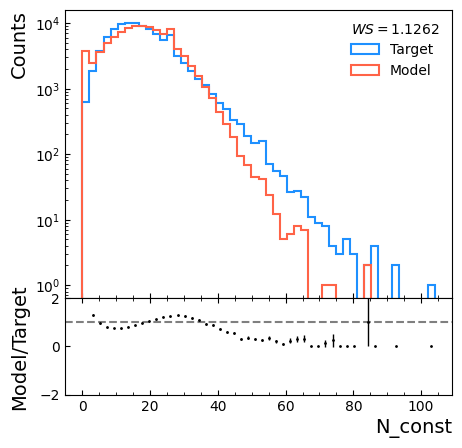

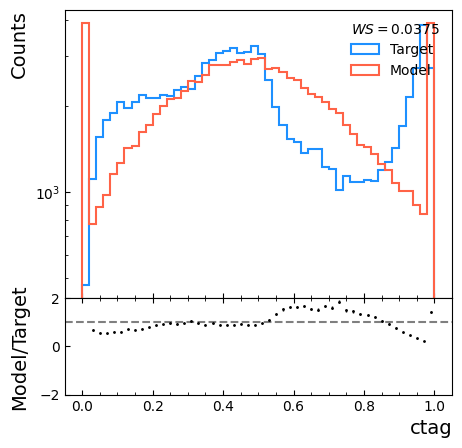

In [54]:
# plot
for i in range(6):
    plot_1d_hist(denoised_data[:, i], reco_val_phys[:, i], label=reco_features[i], title=f'Denoised vs Real {reco_features[i]}', bins=50, logScale=True)

### More

This concludes our overview of Generative ML models for HEP simulation. Hopefully you got a basic idea of the implementations for the different models, and got away with a few key points in mind:

- Low-dimensional data simulation with high-accuracy is actually a really complicate problem! Very different from what the industry looks for when doing image/text/video generation.
- Normalizing Flows are the architecture working best *out of the box*, thanks to its explicit handling of PDFs. This does not mean that some other model with a specific tuning cannot reach the same performance.
- Generative models leverage different ideas, but they all start from a *latent space* (typically a Gaussian one) to generate novel samples in the *target space* (the training data).

Obviously, this was just one of the possible use cases of this family of models. Thier capabilities are really useful in our field, so you can find all sorts of applications. 

An expanding collection of papers is [at the following website][1].

If you are interested in Normalizing Flows, and are curious to see what's the best performance on the problem we discussed in this exercise, please check out [the following paper][2].

If you have any question left, email me at francesco.vaselli AT cern.ch!

[1]: https://iml-wg.github.io/HEPML-LivingReview/
[2]: https://arxiv.org/abs/2402.13684